#  Install package

In [9]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai

# Import package

In [10]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

import base64

import pickle


# Define Solution class
Please run the following cell to define the functions

In [11]:
%load_ext autoreload
%autoreload 2

import LLM_Cat_Constants as constants
import helper

from LLM_Cat_kernel import Solution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [12]:
# isReview = True
isReview = False

In [13]:
task_name ='Census_map'
TASK = r'''1. Create a thematic map to show the Census block group population. The location is Centre County, PA, USA. 
2. Carefuly design the map, make it beautiful and aesthetic appeal. The title, north arrow, scalebar, legend, and designer are needed. The designer is "LLM-Cat".
3. The map dimension is letter (8*11 inches) size.
'''

# 4. You need to design beautiful map elements such as color schemes.

DATA_LOCATIONS = [
    """Population file, GeoPackage format: D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg. Only one layer, no need to load it using a layer name. The population is in the 'totalpopulation' column. The map projection is Lambert Conformal Conic, EPSG 6564, StatePlane Pennsylvania South. The unit is meter.
    """
]

save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
# model = r'gpt-4-turbo-preview'
model = r'gpt-4-turbo'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional cartographer and programmer good at Python. You have worked on cartography more than 20 years, and know every detail and pitfall when visulizing spatial data and coding. You know well how to set up workflows for cartography tasks. You have significant experence on visualizing spatial data and graph theory. You are also experienced on generating map using Matplotlib, GeoPandas and other interative Python packages, such as Plotly.
 

Your task: Generate a graph (data structure) only, whose nodes are a series of consecutive steps to make a map, including visualize the data, add map element such as title, legend, scalebar, label, and annotaion:  
 1. Create a thematic map to show the Census block group population. The location is Centre County, PA, USA. 
2. Carefuly design the map, make it beautiful and aesthetic appeal. The title, north arrow, scalebar, legend, and designer are needed. The designer is "LLM-Cat".
3. The map dimension

## Get graph code from GPT API

In [14]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Step 1: Load Census block group population data
G.add_node("population_data_path", node_type="data", data_path="D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg", description="Path to population GeoPackage")
G.add_node("load_population_data", node_type="operation", description="Load population data from GeoPackage")
G.add_edge("population_data_path", "load_population_data")
G.add_node("population_gdf", node_type="data", description="GeoDataFrame containing the population data")
G.add_edge("load_population_data", "population_gdf")

# Step 2: Create a thematic map
G.add_node("create_thematic_map", node_type="operation", description="Create thematic map showing population")
G.add_edge("population_gdf", "create_thematic_map")
G.add_node("initial_map", node_type="data", description="Initial map with Census block groups colored by population")
G.add_edge("create_thematic_map", "initial_map")

# Step 3: Add map title
G.add_node("add_title", node_type="operation", description="Add title to the map")
G.add_edge("initial_map", "add_title")
G.add_node("map_with_title", node_type="data", description="Map with title added")
G.add_edge("add_title", "map_with_title")

# Step 4: Add north arrow
G.add_node("add_north_arrow", node_type="operation", description="Add north arrow to the map")
G.add_edge("map_with_title", "add_north_arrow")
G.add_node("map_with_north_arrow", node_type="data", description="Map with north arrow added")
G.add_edge("add_north_arrow", "map_with_north_arrow")

# Step 5: Add scale bar
G.add_node("add_scale_bar", node_type="operation", description="Add scale bar to the map")
G.add_edge("map_with_north_arrow", "add_scale_bar")
G.add_node("map_with_scale_bar", node_type="data", description="Map with scale bar added")
G.add_edge("add_scale_bar", "map_with_scale_bar")

# Step 6: Add legend
G.add_node("add_legend", node_type="operation", description="Add legend indicating population ranges")
G.add_edge("map_with_scale_bar", "add_legend")
G.add_node("map_with_legend", node_type="data", description="Map with legend added")
G.add_edge("add_legend", "map_with_legend")

# Step 7: Include designer credits
G.add_node("add_designer_credit", node_type="operation", description="Add designer credit 'LLM-Cat' to the map")
G.add_edge("map_with_legend", "add_designer_credit")
G.add_node("final_map", node_type="data", description="Final map with all elements included")
G.add_edge("add_designer_credit", "final_map")

# Save the graph
nx.write_graphml(G, "D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\Census_map\\Census_map.graphml")

## Execute code to generate the solution graph

In [15]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\Census_map.html


## Generate prompts and code for operations (functions)

In [16]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Description: Load population data from GeoPackage
    # population_data_path: Path to the GeoPackage containing census block group data
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf
import geopandas as gpd
import matplotlib.pyplot as plt

def create_thematic_map(population_gdf):
    # Description: Create thematic map showing population
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf = population_gdf.to_crs(epsg=6564)  # Ensure the map uses the StatePlane Pennsylvania South projection
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        legend_kwds={'label': "Population by Block Group",
                                     'orientation': "horizontal"})
    ax.set_title("Population Distribution in Centre County, PA")
    ax.set_axis_off()
    initial_map = fig
    return initial_map
import matplotlib.pyplot as plt

def add_title(initial_map):
    # Description: Add title to the map
    ax = initial_map.axes[0]
    ax.set_title("Thematic Map of Centre County, PA: Census Block Group Population", fontsize=14, fontweight='bold', color='darkblue')
    map_with_title = initial_map
    return map_with_title
def add_north_arrow(map_with_title):
    # Description: Add north arrow to the map
    ax = map_with_title.axes[0]
    # Adding a north arrow. The coordinates (x, y) position the arrow on the plot.
    # Adjust x, y, width, and height for appropriate placement in your figure.
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, color='blue')
    map_with_north_arrow = map_with_title
    return map_with_north_arrow
import matplotlib.pyplot as plt

def add_scale_bar(map_with_north_arrow):
    # Description: Add scale bar to the map
    ax = map_with_north_arrow.axes[0]
    # Define the scale bar parameters (length and location in the axes)
    scale_len = 5000  # scale length in meters
    scale_x = 0.1  # x position of scale bar start
    scale_y = 0.1  # y position of scale bar
    scale_color = 'black'  # color of scale bar
    
    # Draw the scale bar on the map
    ax.plot([scale_x, scale_x + scale_len / 6564], [scale_y, scale_y], color=scale_color, linewidth=2, transform=ax.transAxes)
    ax.text(scale_x, scale_y - 0.005, '0', verticalalignment='top', horizontalalignment='right', color=scale_color, transform=ax.transAxes)
    ax.text(scale_x + scale_len / 6564, scale_y - 0.005, f'{scale_len} m', verticalalignment='top', horizontalalignment='left', color=scale_color, transform=ax.transAxes)
    
    map_with_scale_bar = map_with_north_arrow
    return map_with_scale_bar
import matplotlib.pyplot as plt

def add_legend(map_with_scale_bar):
    # Description: Add legend indicating population ranges
    ax = map_with_scale_bar.axes[0]
    # Manually defining the breaks for population classes
    # You can choose different styles and color maps for your data characteristics
    population_classes = [0, 500, 1000, 5000, 10000, 20000]
    cmap = plt.cm.viridis  # Select a colormap
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # Add the colorbar to the figure
    cbar = map_with_scale_bar.colorbar(sm, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('Population Ranges')
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['0-500', '501-1,000', '1,001-5,000', '5,001-10,000', '10,001-20,000'])
    
    map_with_legend = map_with_scale_bar
    return map_with_legend
def add_designer_credit(map_with_legend):
    # Description: Ad

## Generate prompts and code for assembly program

In [17]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import matplotlib.pyplot as plt

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf = population_gdf.to_crs(epsg=6564)
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        legend_kwds={'label': "Population by Block Group",
                                     'orientation': "horizontal"})
    ax.set_title("Population Distribution in Centre County, PA")
    ax.set_axis_off()
    initial_map = fig
    return initial_map

def add_title(initial_map):
    ax = initial_map.axes[0]
    ax.set_title("Thematic Map of Centre County, PA: Census Block Group Population", fontsize=14, fontweight='bold', color='darkblue')
    map_with_title = initial_map
    return map_with_title

def add_north_arrow(map_with_title):
    ax = map_with_title.axes[0]
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, color='blue')
    map_with_north_arrow = map_with_title
    return map_with_north_arrow

def add_scale_bar(map_with_north_arrow):
    ax = map_with_north_arrow.axes[0]
    scale_len = 5000
    scale_x = 0.1  
    scale_y = 0.1  
    scale_color = 'black' 
    
    ax.plot([scale_x, scale_x + scale_len / 6564], [scale_y, scale_y], color=scale_color, linewidth=2, transform=ax.transAxes)
    ax.text(scale_x, scale_y - 0.005, '0', verticalalignment='top', horizontalalignment='right', color=scale_color, transform=ax.transAxes)
    ax.text(scale_x + scale_len / 6564, scale_y - 0.005, f'{scale_len} m', verticalalignment='top', horizontalalignment='left', color=scale_color, transform=ax.transAxes)
    
    map_with_scale_bar = map_with_north_arrow
    return map_with_scale_bar

def add_legend(map_with_scale_bar):
    ax = map_with_scale_bar.axes[0]
    population_classes = [0, 500, 1000, 5000, 10000, 20000]
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = map_with_scale_bar.colorbar(sm, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('Population Ranges')
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['0-500', '501-1,000', '1,001-5,000', '5,001-10,000', '10,001-20,000'])
    
    map_with_legend = map_with_scale_bar
    return map_with_legend

def add_designer_credit(map_with_legend):
    ax = map_with_legend.axes[0]
    credit_text = "Design by: LLM-Cat"
    ax.text(0.95, 0.05, credit_text, verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='gray', fontsize=10, style='italic')
    final_map = map_with_legend
    return final_map

def assembly_solution():
    population_gdf = load_population_data()
    initial_map = create_thematic_map(population_gdf)
    map_with_title = add_title(initial_map)
    map_with_north_arrow = add_north_arrow(map_with_title)
    map_with_scale_bar = add_scale_bar(map_with_north_arrow)
    map_with_legend = add_legend(map_with_scale_bar)
    final_map = add_designer_credit(map_with_legend)
    final_map.savefig('output_map.png', dpi=300)

assembly_solution()

## Execute assembly code

In [18]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))
solution.all_code = all_code



-------------- Running code (trial # 1/10) --------------


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 168, in <module>
    assembly_solution()
  File "Complete program", line 164, in assembly_solution
    map_with_legend = add_legend(map_with_scale_bar)
  File "Complete program", line 145, in add_legend
    cbar.set_ticklabels(['0-500', '501-1,000', '1,001-5,000', '5,001-10,000', '10,001-20,000'])
  File "C:\Users\A\.conda\envs\llm_geo\Lib\site-packages\matplotlib\colorbar.py", line 933, in set_ticklabels
    self._long_axis().set_ticklabels(ticklabels, minor=minor, **kwargs)
  File "C:\Users\A\.conda\envs\llm_geo\Lib\site-packages\matplotlib\_api\deprecation.py", line 297, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\A\.conda\envs\llm_geo\Lib\site-packages\matplotlib\axis.py", line 2025, in set_ticklabels
    raise ValueError(
ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not mat

import geopandas as gpd
import matplotlib.pyplot as plt

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf = population_gdf.to_crs(epsg=6564)
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        legend_kwds={'label': "Population by Block Group",
                                     'orientation': "horizontal"})
    ax.set_title("Population Distribution in Centre County, PA")
    ax.set_axis_off()
    initial_map = fig
    return initial_map

def add_title(initial_map):
    ax = initial_map.axes[0]
    ax.set_title("Thematic Map of Centre County, PA: Census Block Group Population", fontsize=14, fontweight='bold', color='darkblue')
    map_with_title = initial_map
    return map_with_title

def add_north_arrow(map_with_title):
    ax = map_with_title.axes[0]
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, color='blue')
    map_with_north_arrow = map_with_title
    return map_with_north_arrow

def add_scale_bar(map_with_north_arrow):
    ax = map_with_north_arrow.axes[0]
    scale_len = 5000
    scale_x = 0.1  # x position as proportion of axes
    scale_y = 0.1  # y position as proportion of axes
    scale_color = 'black'
    # Draw the scale bar
    ax.plot([scale_x, scale_x + scale_len / 6564], [scale_y, scale_y], color=scale_color, linewidth=2, transform=ax.transAxes)
    ax.text(scale_x, scale_y - 0.005, '0', verticalalignment='top', horizontalalignment='right', color=scale_color, transform=ax.transAxes)
    ax.text(scale_x + scale_len / 6564, scale_y - 0.005, f'{scale_len} m', verticalalignment='top', horizontalalignment='left', color=scale_color, transform=ax.transAxes)
    
    map_with_scale_bar = map_with_north_arrow
    return map_with_scale_bar

def add_legend(map_with_scale_bar):
    ax = map_with_scale_bar.axes[0]
    population_classes = [0, 500, 1000, 5000, 10000, 20000]
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('Population Ranges (counts)')
    cbar.set_ticks([(a + b) / 2.0 for a, b in zip(population_classes[:-1], population_classes[1:])])  # Set ticks at the middle of intervals
    cbar.set_ticklabels(['0-500', '501-1,000', '1,001-5,000', '5,001-10,000', '10,001-20,000'])
    
    map_with_legend = map_with_scale_bar
    return map_with_legend

def add_designer_credit(map_with_legend):
    ax = map_with_legend.axes[0]
    credit_text = "Design by: LLM-Cat"
    ax.text(0.95, 0.05, credit_text, verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='gray', fontsize=10, style='italic')
    final_map = map_with_legend
    return final_map

def assembly_solution():
    population_gdf = load_population_data()
    initial_map = create_thematic_map(population_gdf)
    map_with_title = add_title(initial_map)
    map_with_north_arrow = add_north_arrow(map_with_title)
    map_with_scale_bar = add_scale_bar(map_with_north_arrow)
    map_with_legend = add_legend(map_with_scale_bar)
    final_map = add_designer_credit(map_with_legend)
    final_map.savefig('output_map.png', dpi=300)

assembly_solution()

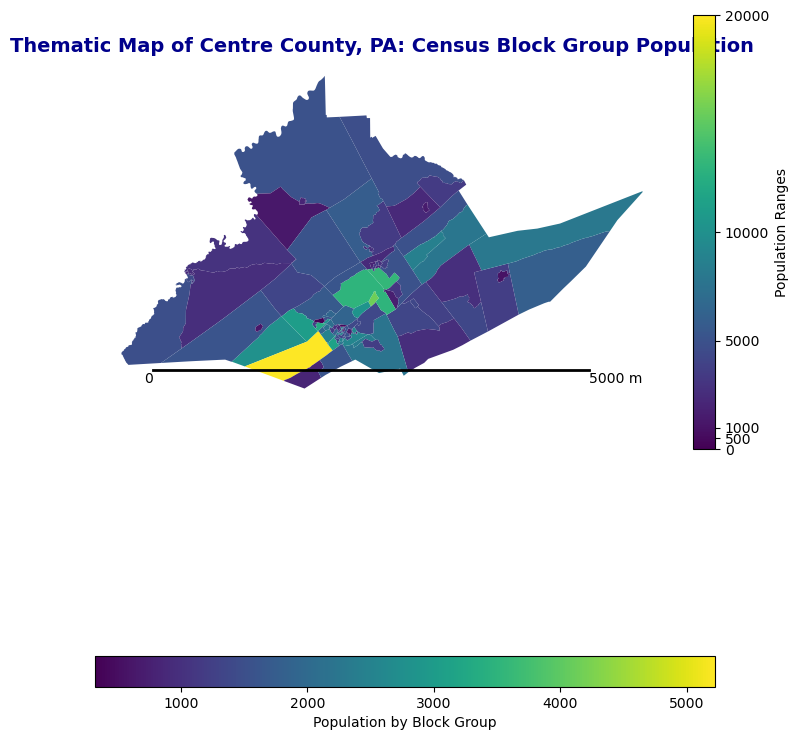

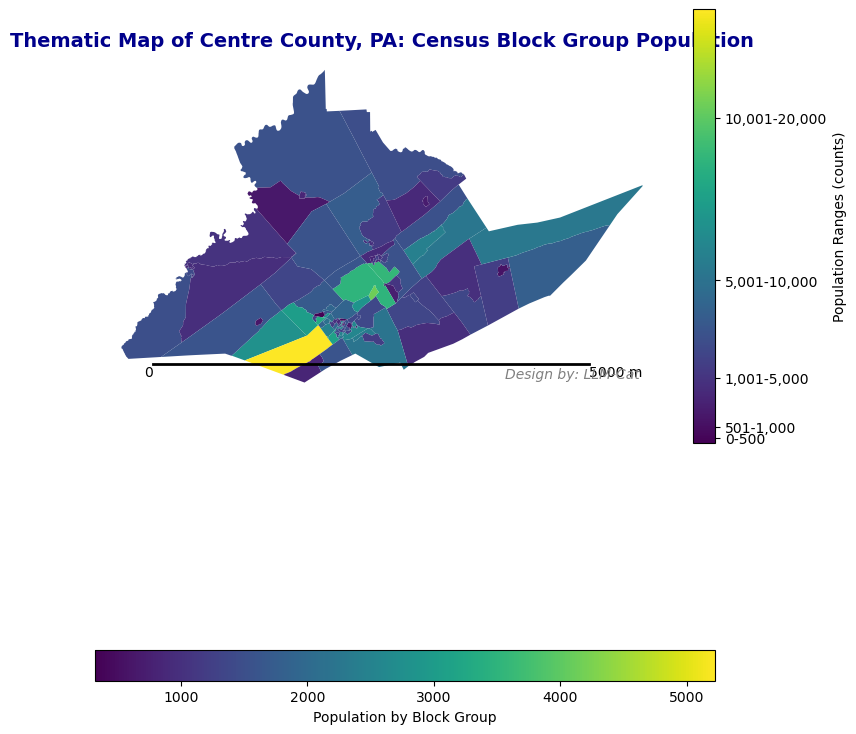

In [19]:
all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

solution.all_code = all_code

display(Code(all_code, language='python'))

In [20]:
# display(Code(all_code, language='python'))

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\LLM_Cat_Constants.py:42: SyntaxWarning: invalid escape sequence '\T'
  'The node attributes include: 1) node_type (data or operation), 2) data_path (data node only, set to "" if not given), and description. E.g., {"name": "County boundary", "data_type": "data", "data_path": r"D:\Test\county.shp",  "description": "County boundary for the study area"}.',


# Beautify map

In [21]:
print(solution.get_review_prompt())

Your role: A professional cartographer. You have worked on cartography more than 20 years, and know how to design an aesthietic appeal map. Your current job is to review the map generated by AI. You need to point out the issues of the given map in detail, so that the AI can improve the map later. Note that AI makes the map via generated code, so your comments should be suitable for improvements by code. The requirements of the map are also provided.
 
Your task: Observe the given map carefully using the viewpoint of an experienced cartographer. 

Requirements: 
1. Elaborate the issues, then provide the specific and actionable improvements, such as 'move the legend to the up-left to void obscuring'. If you think there is no issue, no need to mention.
2. Whether the title semantically meet the data and map requirement.
3. Whether the fonts and font sizes are suitable and hierachical.
4. Wheter the map is in the center.
5. Whether the legend or colorbar use the some color scheme.
6. Wheth

## Map review

1. The title "Thematic Map of Centre County, PA: Census Block Group Population" is semantically accurate and provides a clear description of the data represented.
2. There is a color legend at the top right and a color bar at the bottom; only one color guide is necessary. Remove the bottom color bar to reduce redundancy.
3. Both the legend on the top right and the scale bar at the bottom should have their font sizes increased for better readability.
4. Move the title slightly upwards or increase its margin from the top boundary of the map to ensure it is center-aligned with the map body vertically.
5. Ensure consistency in color scheme usage in both the top-right legend and the bottom color bar before one is removed; they currently display different color intervals and scales.
6. The position of the scale bar at the bottom overlaps slightly with the map outline, which can be misleading. Move the scale bar slightly to the right to clear the boundary of the map.
7. There does not appear 

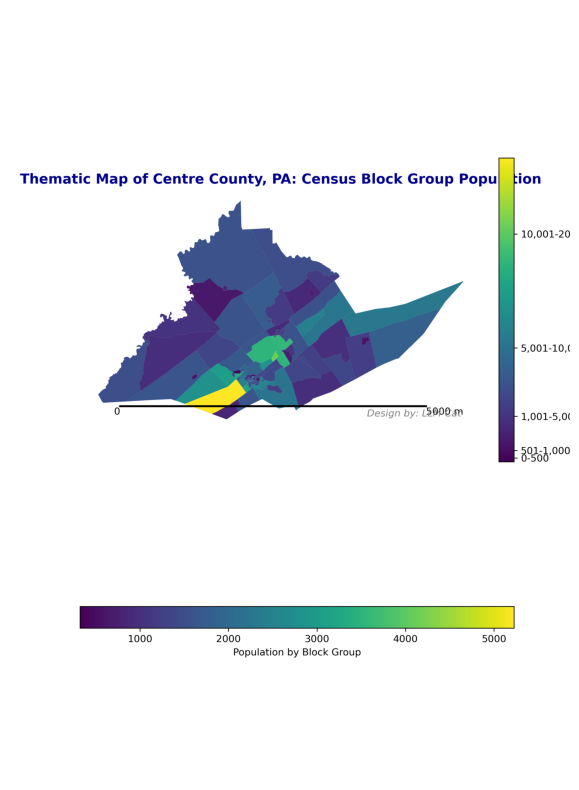

In [22]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\output_map.png"

# Getting the base64 string
base64_image = encode_image(image_path)

from PIL import Image
import matplotlib.pyplot as plt

def show_map():
    image = Image.open(image_path)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    plt.imshow(image)


solution.ask_LLM_to_review_map(map_base64=base64_image, model='gpt-4-turbo')

show_map()

## Beautify 1

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\LLM_Cat_Constants.py:42: SyntaxWarning: invalid escape sequence '\T'
  'The node attributes include: 1) node_type (data or operation), 2) data_path (data node only, set to "" if not given), and description. E.g., {"name": "County boundary", "data_type": "data", "data_path": r"D:\Test\county.shp",  "description": "County boundary for the study area"}.',


Revising the map, trial 1 / 1
Current map issues:
1. The title font size is too small, which may compromise readability.
2. The north arrow is a bit too basic and not very visually appealing.
3. The scale bar lacks clear denomination and does not specify units.
4. The legend on the side has a color gradient that may not clearly relate to the color scheme used in the map itself, leading to potential confusion.
5. The map overall lacks a base map, which can generally improve the contextual understanding of the thematic data.
6. The text 'Design by: LLM-Cat' is very close to the edge, decreasing legibility.

Improvements:
1. Increase the title font size and enhance its visual impact.
2. Use a more stylized north arrow with a proper background for improved visibility.
3. Redefine the scale bar to include units and ensure it's placed where it doesn’t overlap with other textual information.
4. Adjust the legend to use the same color scheme as the main map and enhance its readability.
5. Add 

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load geographic data from a GeoPackage
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    # Creating a matplotlib figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    # Plotting the population data on the map
    base = population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                               cmap='viridis', legend_kwds={'label': "Population by Block Group",
                                                           'orientation': "vertical"})
    # Adding a basemap for geographical context
    ctx.add_basemap(ax, crs=population_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    # Adding a title to the map
    ax.set_title("Population Distribution in Centre County, PA", fontsize=18, fontweight='bold', color='darkblue')
    # Turn off axes for clean map display
    ax.set_axis_off()
    return fig, ax

def add_custom_north_arrow(ax, location=(0.95, 0.95)):
    # Adding a custom north arrow to the map
    ax.annotate("", xy=(location[0], location[1]-0.1), xycoords='axes fraction',
                xytext=(location[0], location[1]), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="-|>", lw=2.5, color="black"))
    ax.text(location[0], location[1]-0.12, 'N', ha='center', va='top', fontsize=20, weight='bold', family='sans-serif', color='black')

def add_scale_bar(ax, length=5):
    # Adding a scale bar to the map
    scalebar = ScaleBar(1, units='m', length_fraction=0.25, location='lower right', frameon=False,
                        scale_loc='bottom', color='black', label_formatter=lambda value, unit: f'{int(value)} m',
                        font_properties={'size': 12})
    ax.add_artist(scalebar)

def add_legend(fig, ax):
    # Defining population classes for the legend
    population_classes = [0, 500, 1000, 5000, 10000, 20000]
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('Population Ranges (Numbers)')
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['<500', '501-1000', '1001-5000', '5001-10000', '10001-20000', '>20000'])

def add_designer_credit(ax):
    # Displaying the designer's credit on the map
    ax.text(0.01, 0.01, 'Design by: LLM-Cat', transform=ax.transAxes, fontsize=12, color='gray', fontstyle='italic')

def assembly_solution():
    population_gdf = load_population_data()
    fig, ax = create_thematic_map(population_gdf)
    add_custom_north_arrow(ax)
    add_scale_bar(ax)
    add_legend(fig, ax)
    add_designer_credit(ax)
    fig.savefig('output_map.png', dpi=300)

assembly_solution()

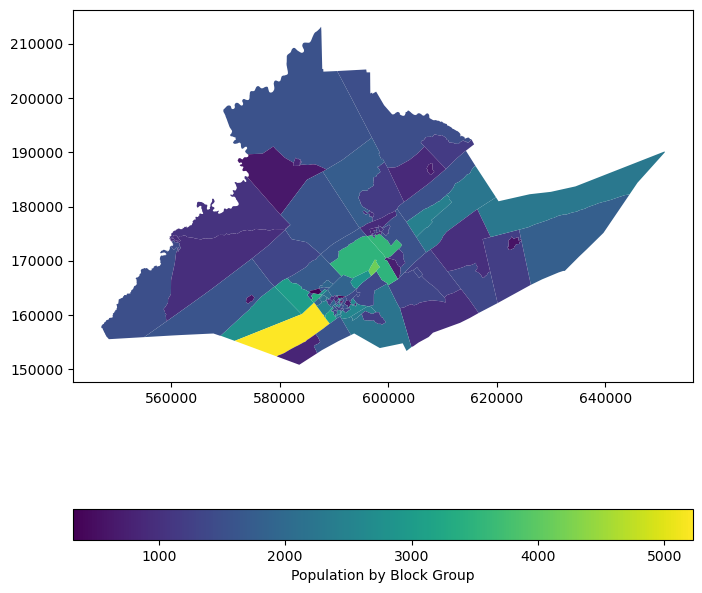

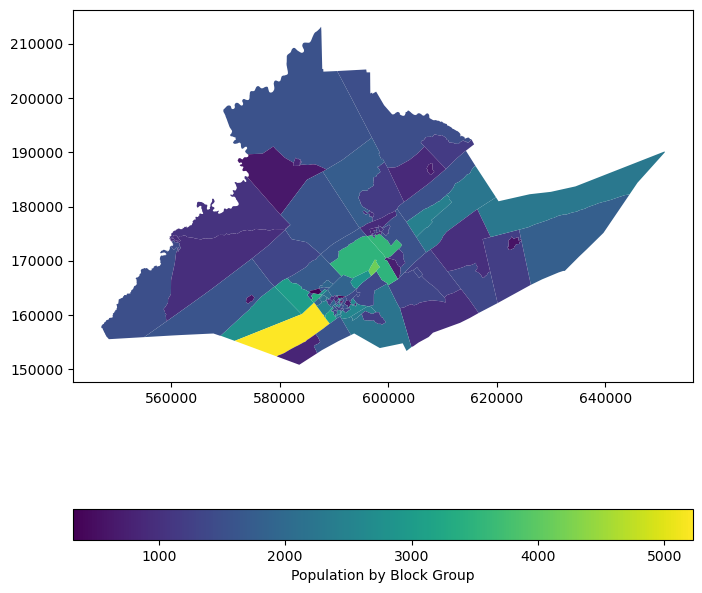

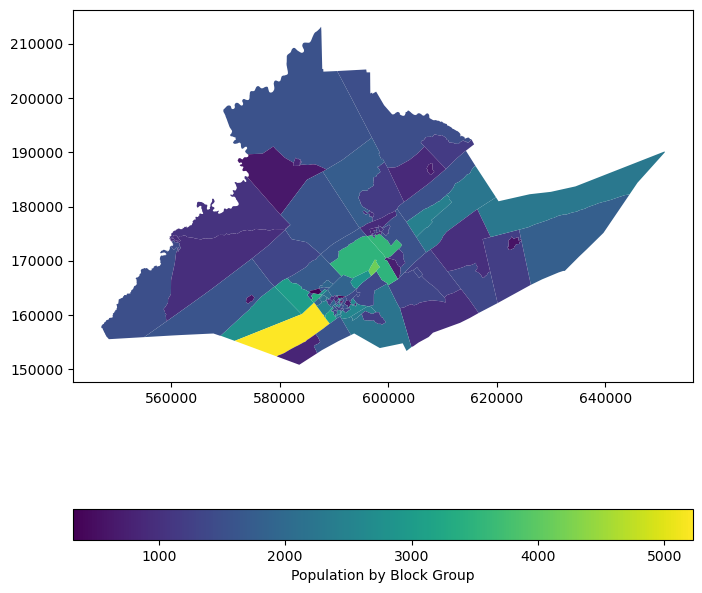

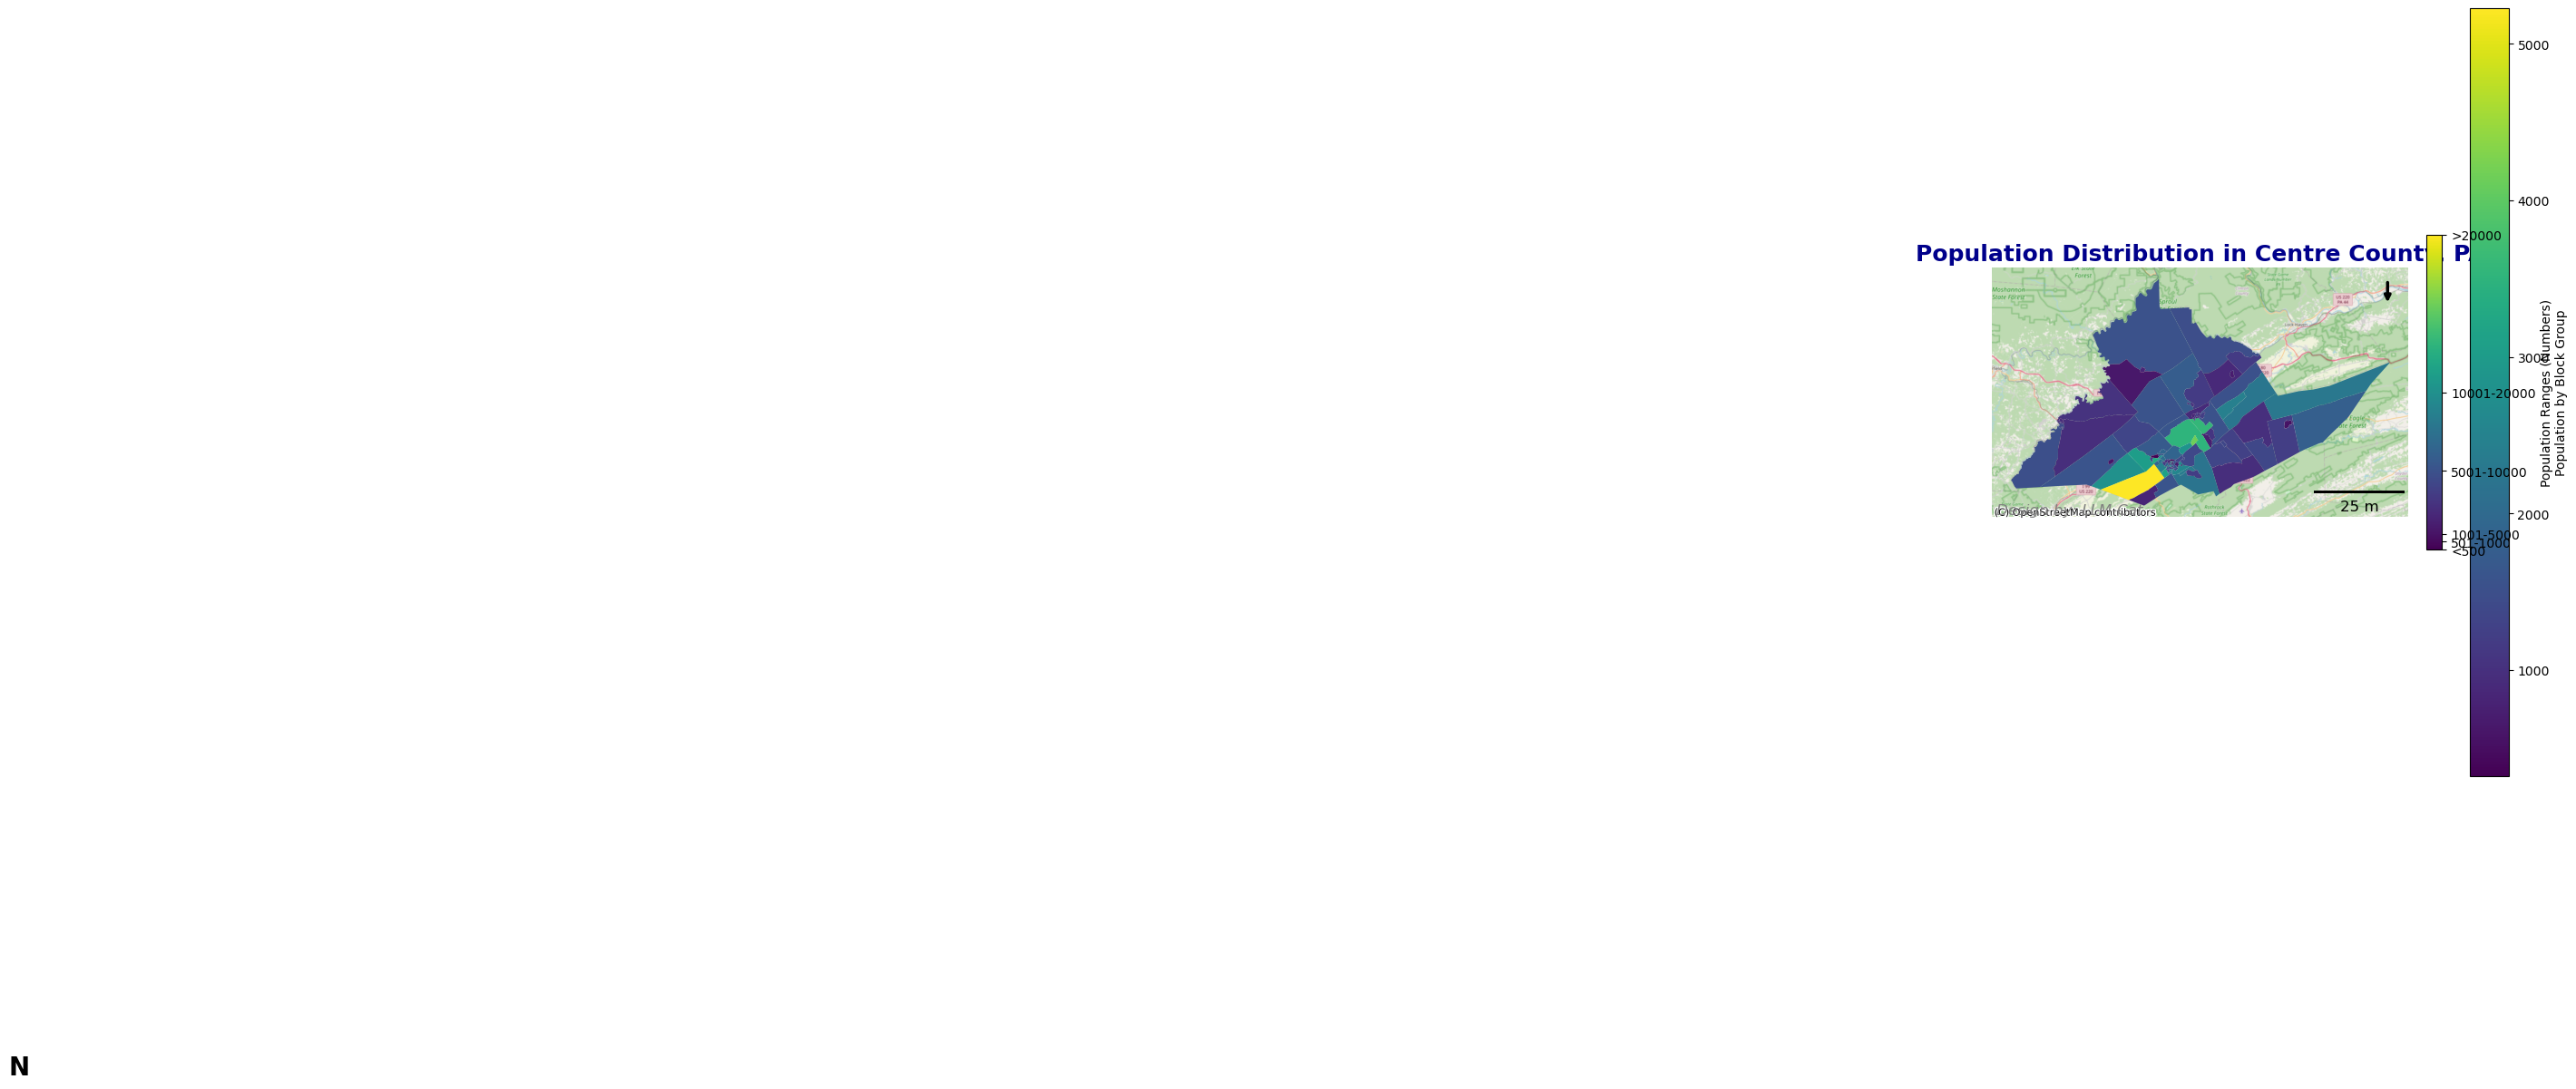

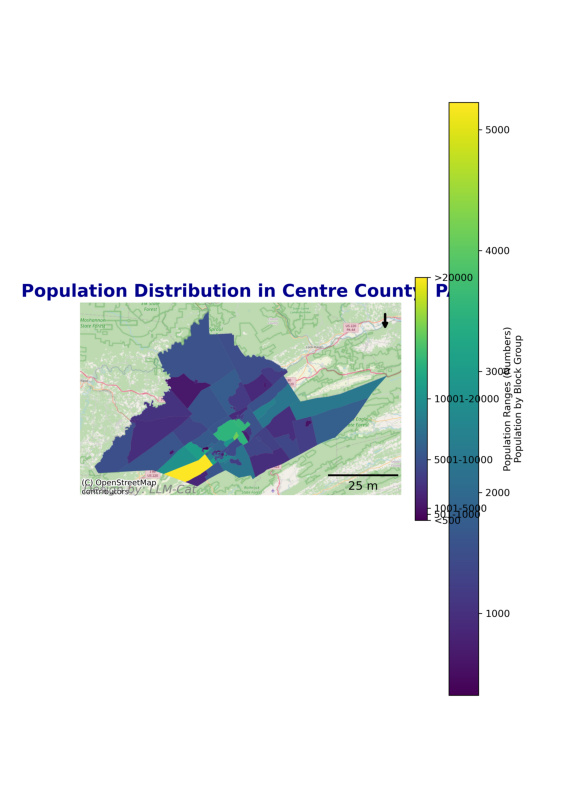

In [23]:
# solution.get_beautify_text_prompt(solution.all_code)

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
 
 
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

  
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 2

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\LLM_Cat_Constants.py:42: SyntaxWarning: invalid escape sequence '\T'
  'The node attributes include: 1) node_type (data or operation), 2) data_path (data node only, set to "" if not given), and description. E.g., {"name": "County boundary", "data_type": "data", "data_path": r"D:\Test\county.shp",  "description": "County boundary for the study area"}.',


Revising the map, trial 1 / 1
Current map issues and approaches for improvements:

1. **Title Font and Positioning**: The font size of the title is fairly good but can be enhanced further for better visibility.
  
2. **Legend Readability and Detail**: Although the legend is clear, it can benefit from more detailed categorization and better alignment with the map theme. Additionally, the color transitions can be made more discernible.

3. **North Arrow Style and Positioning**: The north arrow should be more pronounced and possibly integrated better with the map's aesthetics.

4. **Scale Bar**: The scale bar lacks units and could be more visually integrated.

5. **Map Color Scheme**: The map uses a viridis color map which is effective for numeric ranges but could be enhanced for visual perception and to aid visual differentiation between categories.

6. **Designer Credit Styling**: The credit to the designer is a key element but should be subtler and less intrusive.

Below are the improv

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load geographic data from a GeoPackage
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        cmap='coolwarm', legend_kwds={'label': "Population by Block Group",
                                                     'orientation': "vertical"})
    ctx.add_basemap(ax, crs=population_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Centre County Population Distribution", fontsize=22, fontweight='bold', verticalalignment='top')
    ax.set_axis_off()
    return fig, ax

def add_custom_north_arrow(ax, location=(0.1, 0.9)):
    ax.annotate('', xy=(location[0], location[1]-0.05), xycoords='axes fraction',
                xytext=(location[0], location[1]), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=10))
    ax.text(location[0], location[1]-0.08, 'N', ha='center', fontsize=16, weight='bold', style='italic', family='serif', color='black')

def add_scale_bar(ax, length=5):
    scalebar = ScaleBar(1, units='km', length_fraction=0.15, location='lower right', frameon=True, scale_loc='bottom',
                        color='black', label_formatter=lambda value, unit: f'{int(value)} km',
                        font_properties={'size': 14, 'style': 'italic'})
    ax.add_artist(scalebar)

def add_legend(fig, ax):
    population_classes = [0, 100, 500, 1000, 5000, 10000, 20000]
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Population Range')
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['<100', '101-500', '501-1000', '1001-5000', '5001-10,000', '10,001-20,000', '>20,000'])

def add_designer_credit(ax):
    ax.text(0.98, 0.02, 'Designed by LLM-Cat', transform=ax.transAxes, fontsize=10, color='gray', ha='right')

def assembly_solution():
    population_gdf = load_population_data()
    fig, ax = create_thematic_map(population_gdf)
    add_custom_north_arrow(ax)
    add_scale_bar(ax)
    add_legend(fig, ax)
    add_designer_credit(ax)
    fig.savefig('output_map.png', dpi=300)

assembly_solution()

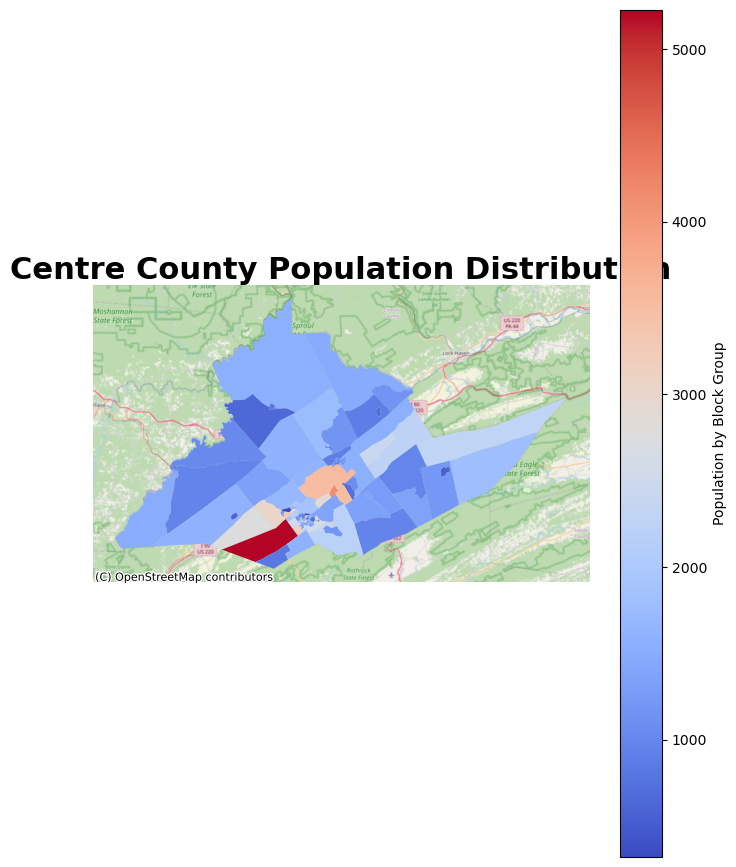

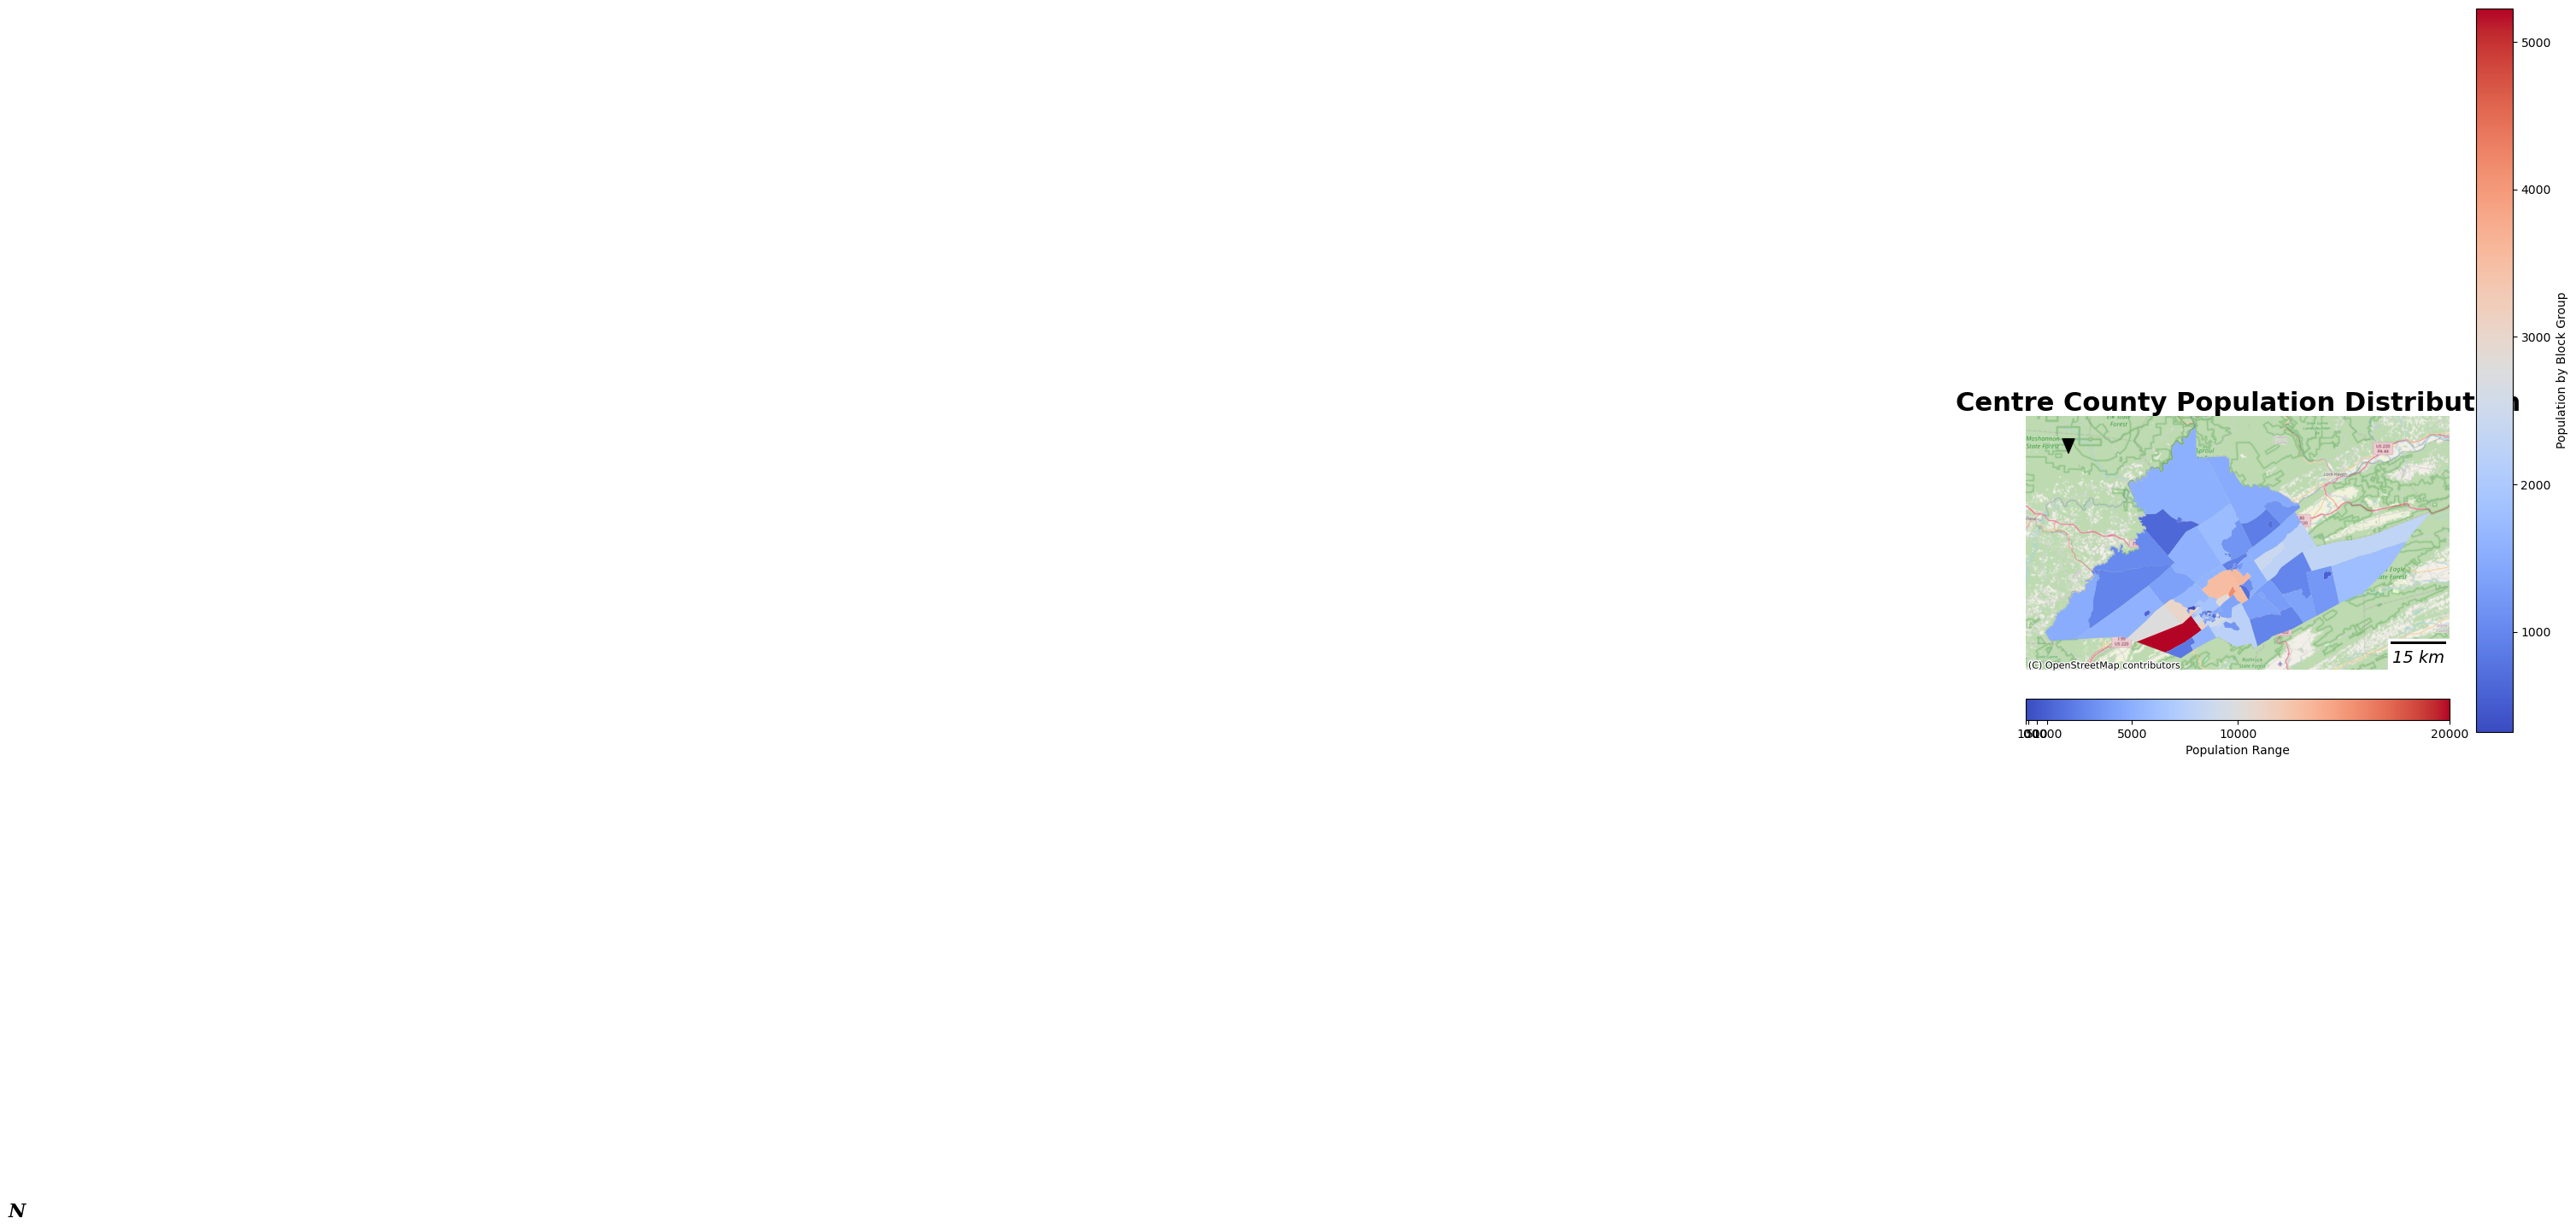

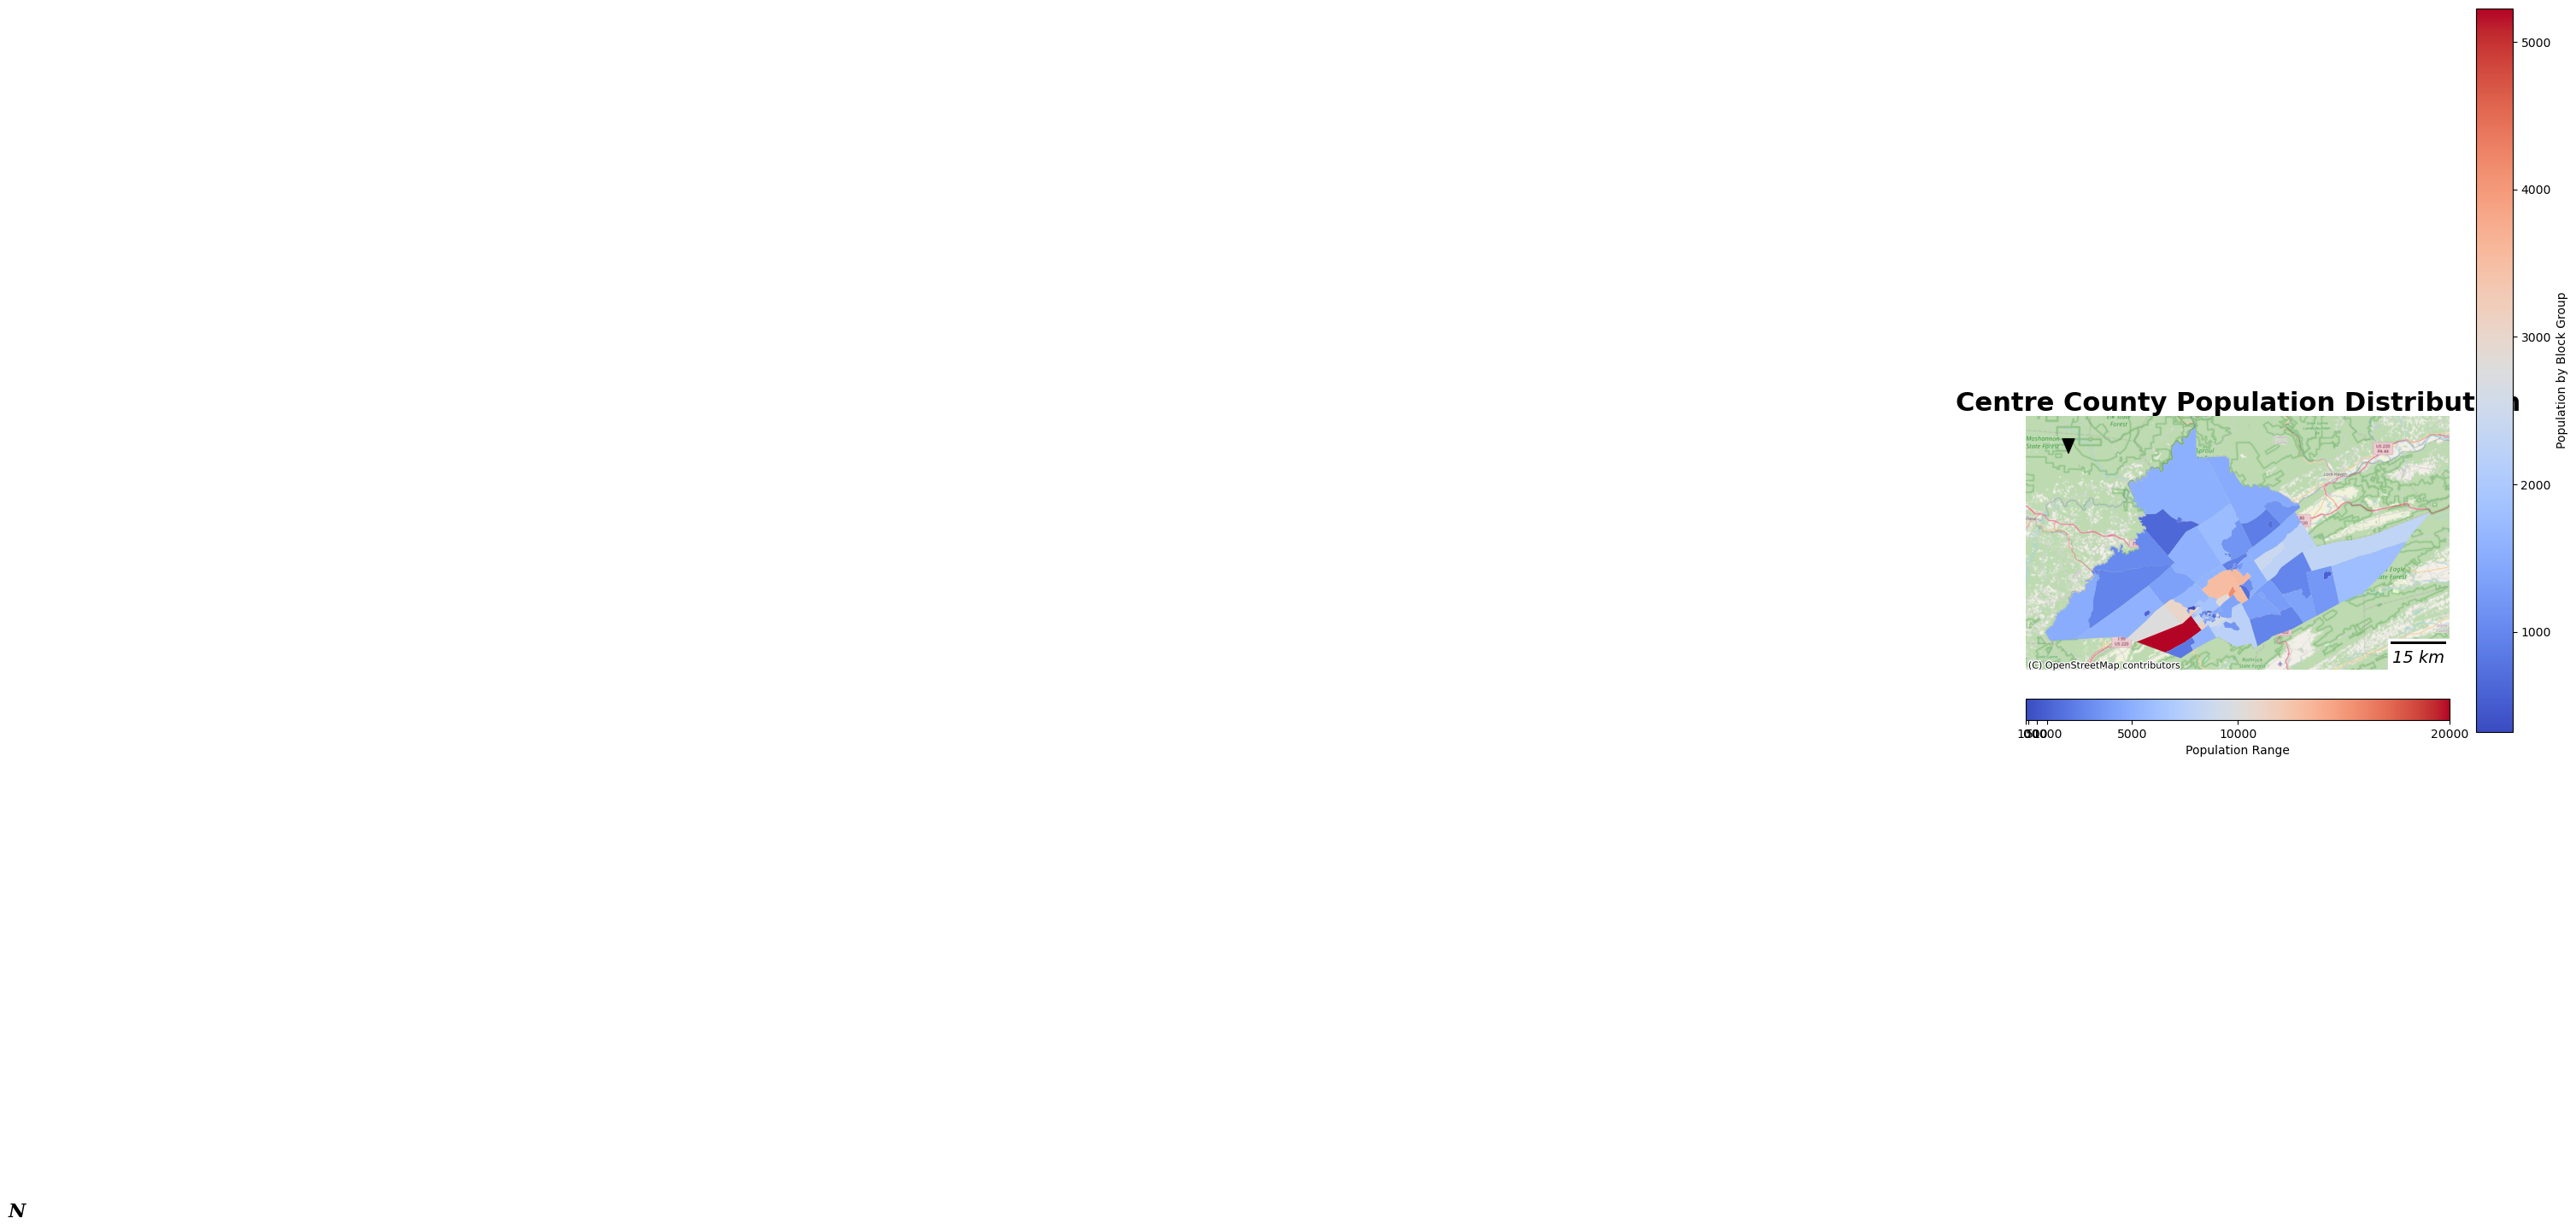

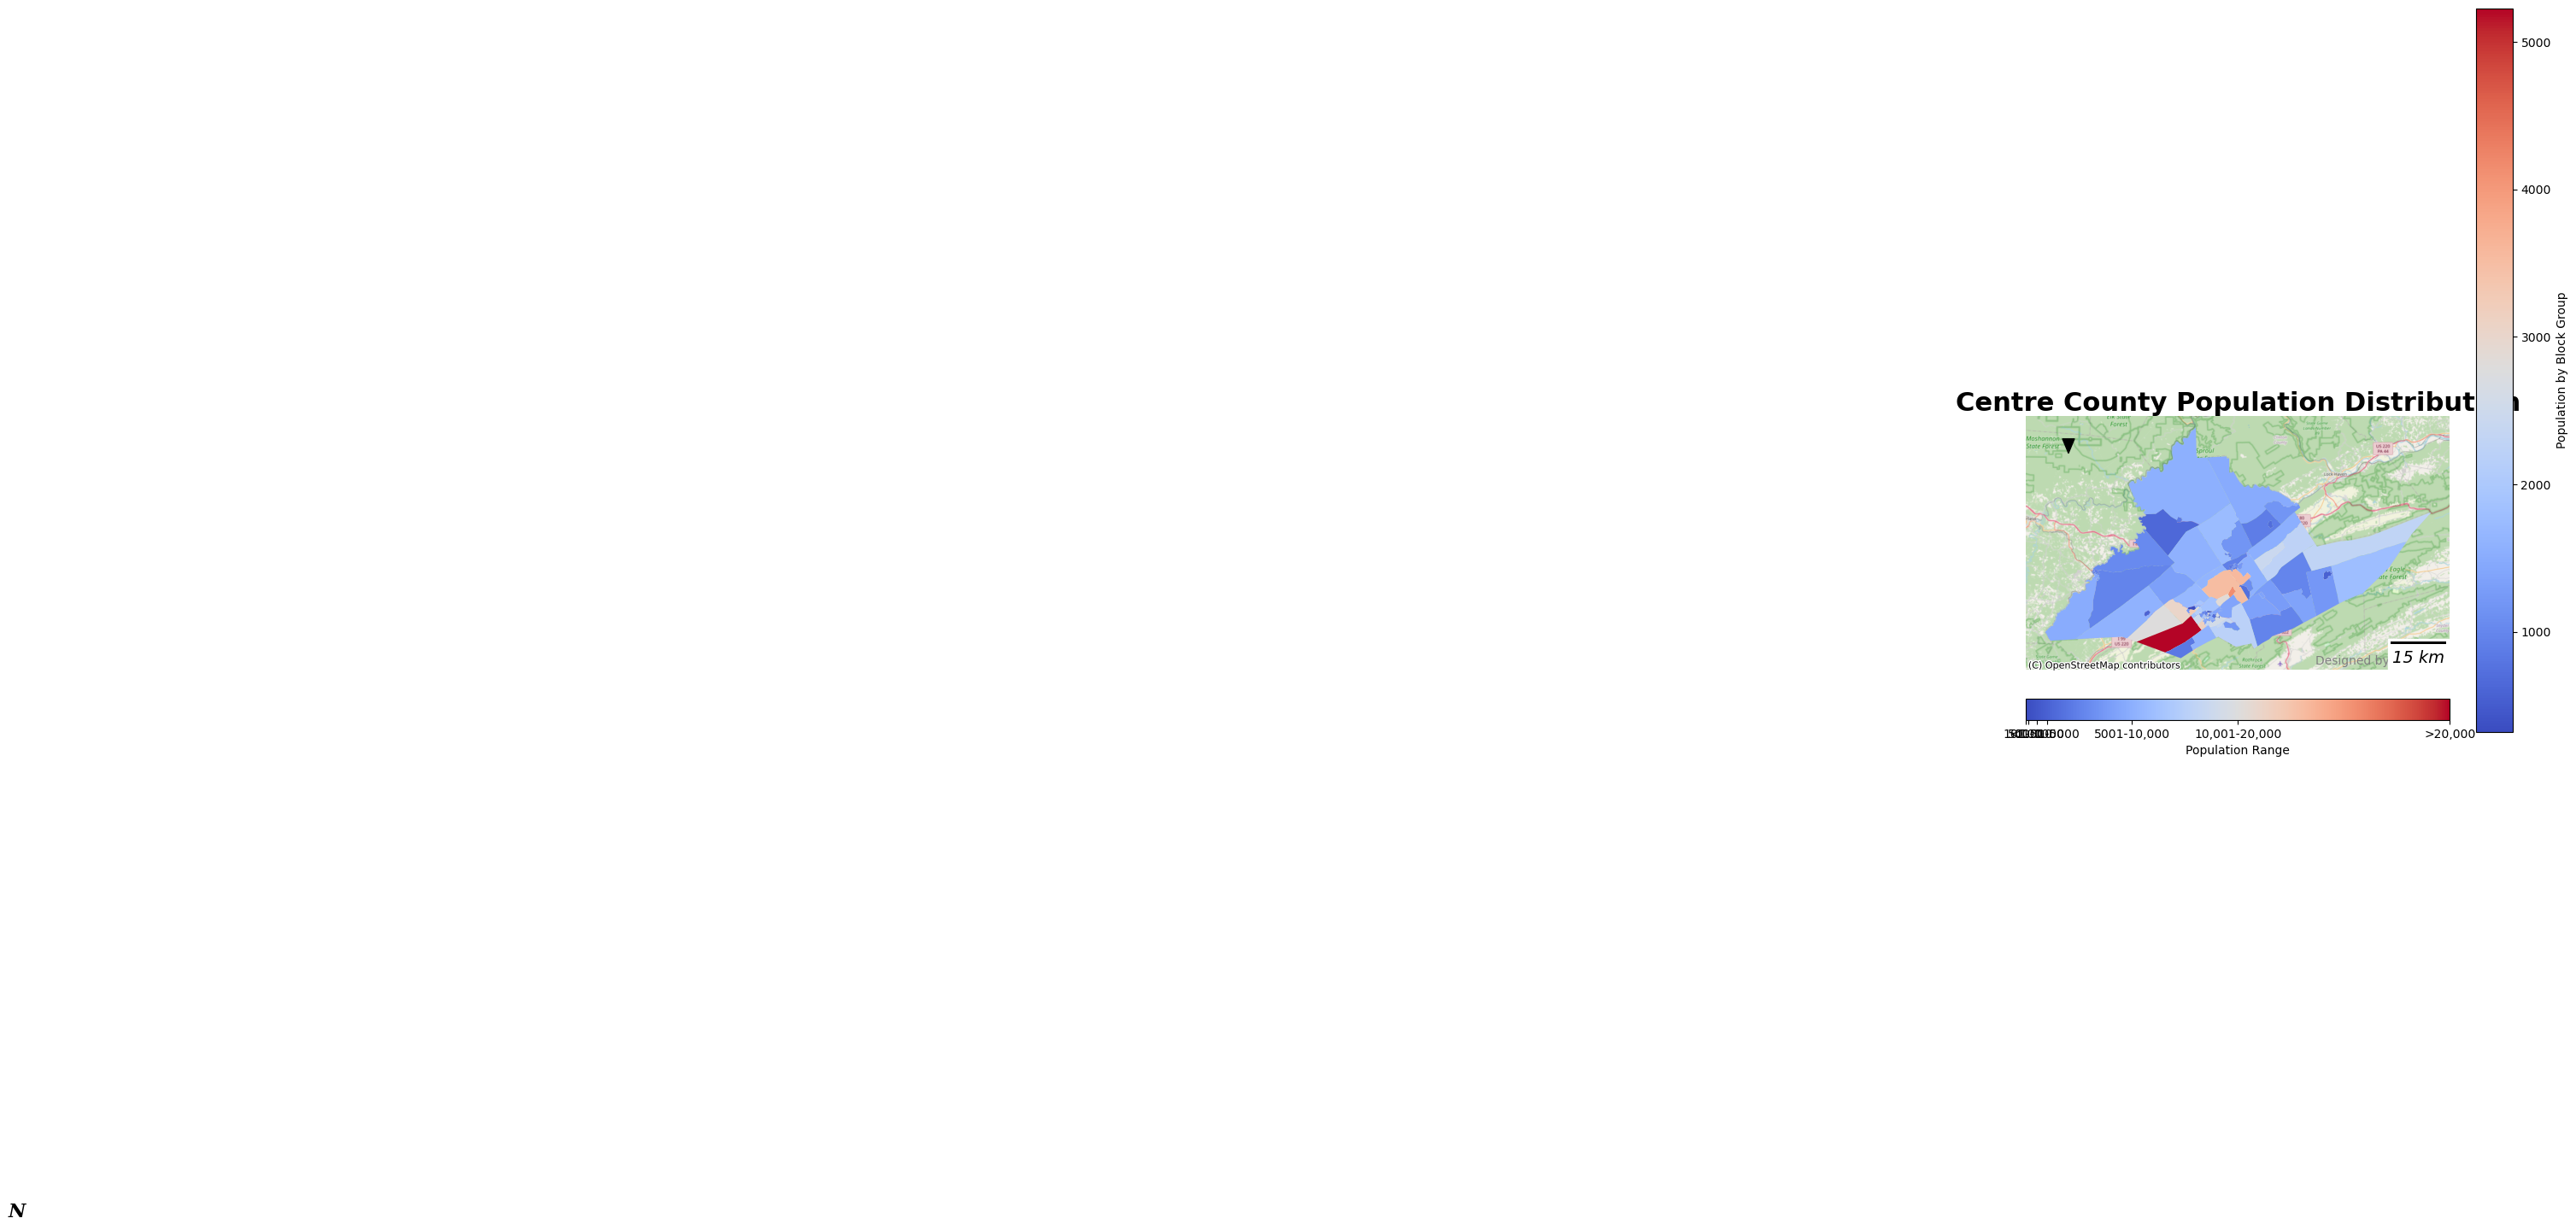

In [24]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()


show_map()
display(Code(all_code, language='python'))



In [25]:
# import pickle

# saved_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\Census_map\Census_map.pkl"
# file = open(saved_fname, 'rb')

# solution = pickle.load(file)

# file.close()
# print(solution.task)

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\LLM_Cat_Constants.py:42: SyntaxWarning: invalid escape sequence '\T'
  'The node attributes include: 1) node_type (data or operation), 2) data_path (data node only, set to "" if not given), and description. E.g., {"name": "County boundary", "data_type": "data", "data_path": r"D:\Test\county.shp",  "description": "County boundary for the study area"}.',


## Beautify 3

Revising the map, trial 1 / 1
Current map issues:
1. **Color Scheme and Legend Clarity**: The color bar on the right dominates the map visually and its color intensity varies greatly, potentially causing misunderstanding of the data distribution.
2. **Title Visibility**: The title, while adequately sized, merges into the map due to color similarity and position.
3. **Scale Bar and North Arrow Placement**: The scale bar and north arrow, placed at the bottom, are somewhat detached from the main visual focus, making them less effective in conveying spatial orientation and scale.
4. **Overlay and Clarity**: The base map details are visible beneath the thematic layer, which may cause visual clutter affecting the readability of population data.
5. **Legend Position and Format**: The color bar legend is placed horizontally at the bottom which is unconventional for this kind of side color bar. Moreover, the end labels ("<100" and ">20,000") are potentially misleading.

Improvements:
1. Adjust 

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load geographic data from GeoPackage
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        cmap='Oranges', legend_kwds={'label': "Population by Block Group",
                                                     'orientation': "horizontal"})
    ctx.add_basemap(ax, crs=population_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    ax.set_title("Centre County Population Distribution", fontsize=24, fontweight='bold', color='darkred', pad=20)
    ax.set_axis_off()
    return fig, ax

def add_custom_north_arrow(ax, location=(0.1, 0.9)):
    ax.annotate('', xy=(location[0], location[1]-0.05), xycoords='axes fraction',
                xytext=(location[0], location[1]), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=1, headwidth=8))
    ax.text(location[0], location[1]-0.08, 'N', ha='center', fontsize=12, weight='bold', family='serif', color='black')

def add_scale_bar(ax, length=8):
    scalebar = ScaleBar(1, units='km', length_fraction=0.25, location='lower left', frameon=False,
                        color='black', label_formatter=lambda value, unit: f'{value} {unit}',
                        font_properties={'size': 12, 'style': 'italic'})
    ax.add_artist(scalebar)

def add_legend(fig, ax):
    population_classes = [0, 100, 500, 1000, 5000, 10000, 20000]
    cmap = plt.get_cmap('Oranges')
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Population Range', rotation=270, labelpad=20)
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['<100', '101-500', '501-1000', '1001-5000', '5001-10,000', '10,001-20,000', '>20,000'])

def add_designer_credit(ax):
    ax.text(0.98, 0.02, 'Designed by LLM-Cat', transform=ax.transAxes, fontsize=12, color='gray', ha='right')

def assembly_solution():
    population_gdf = load_population_data()
    fig, ax = create_thematic_map(population_gdf)
    add_custom_north_arrow(ax)
    add_scale_bar(ax)
    add_legend(fig, ax)
    add_designer_credit(ax)
    fig.savefig('output_map.png', dpi=300)

assembly_solution()

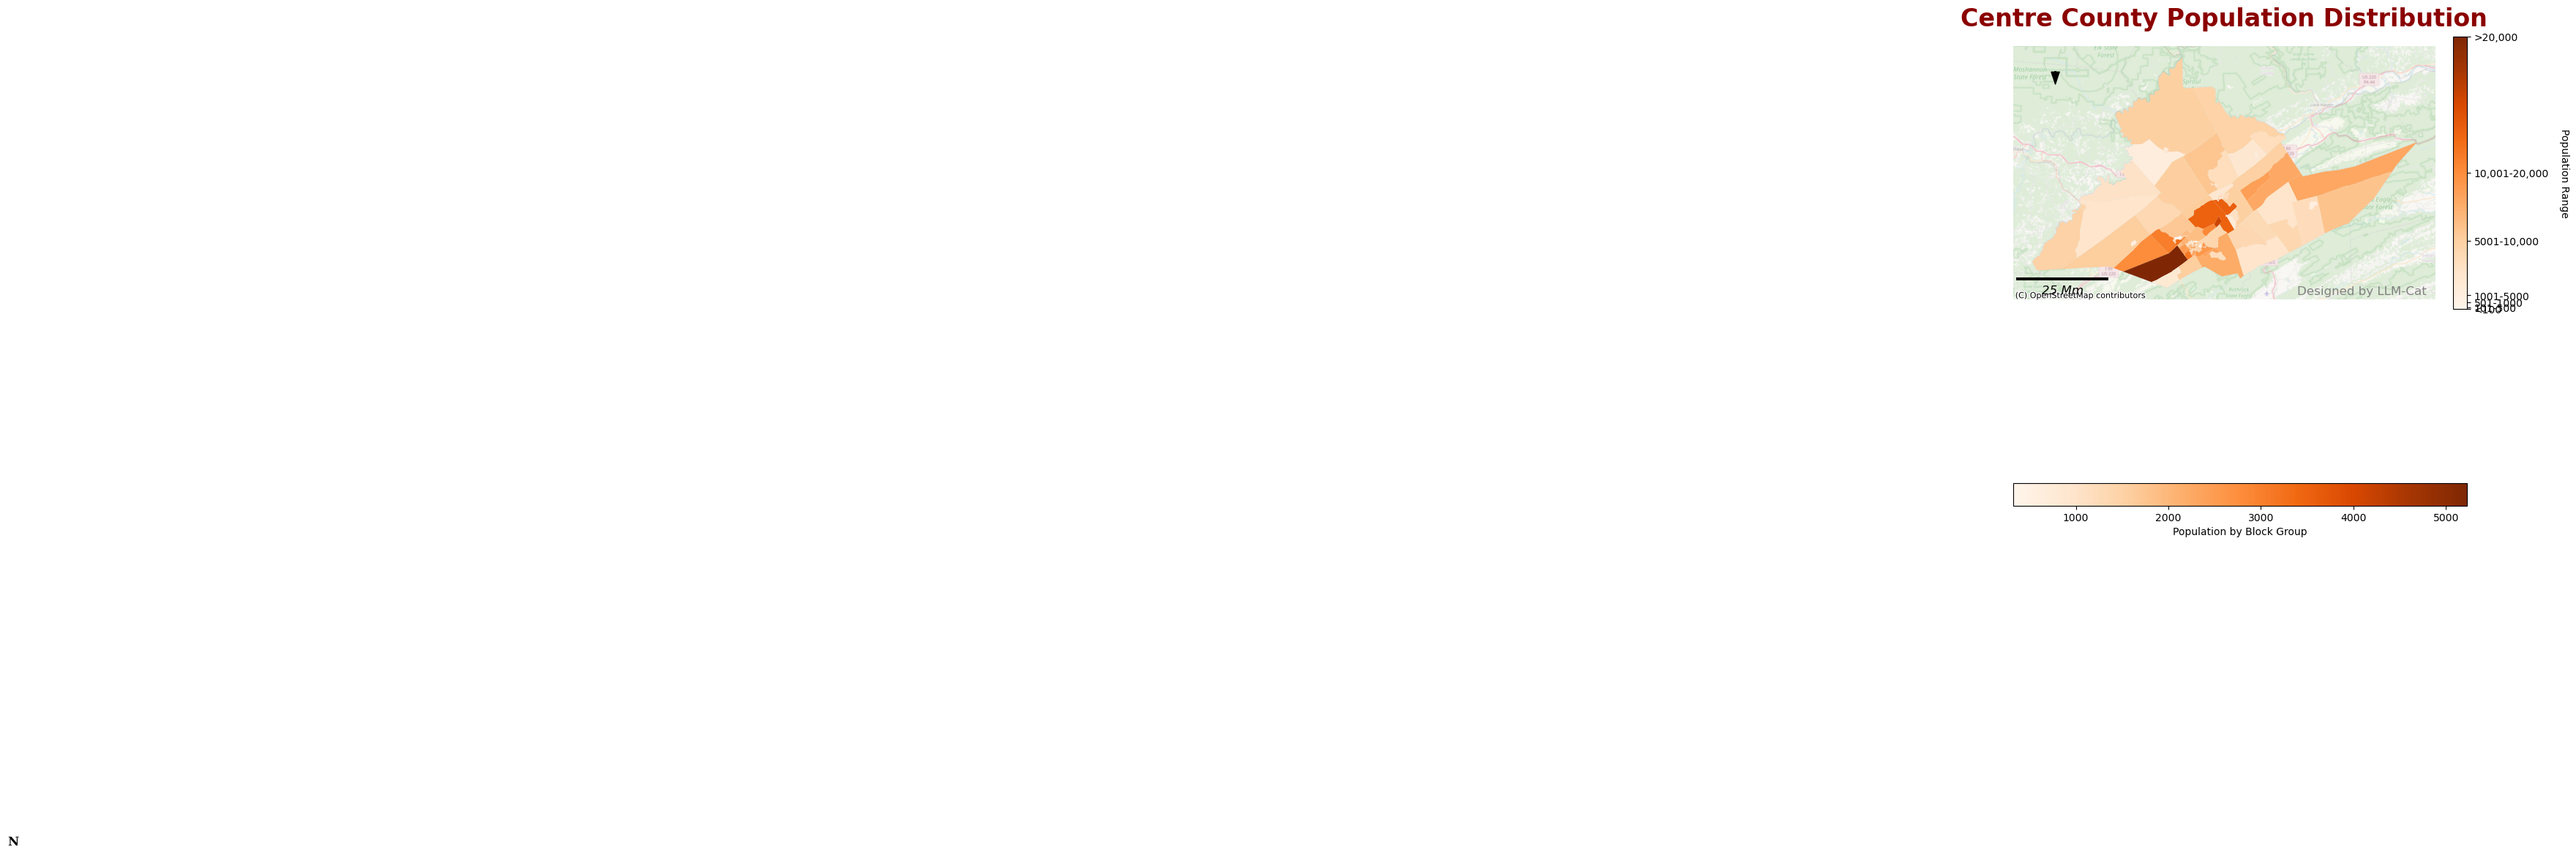

In [26]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 4

Revising the map, trial 1 / 1
### Current Map Issues:
1. **Title Font and Position**: Although the title is relatively visible, its position could be improved to be more balanced and visually engaging.
2. **Legend Clarity and Position**: The legend in the current map uses a horizontal bar, which is less efficient for understanding than a vertical bar when comparing data magnitudes. Also, the placement of both legends (horizontal bar and the population range) could be optimized for better readability and aesthetics.
3. **North Arrow Style and Position**: The north arrow is too small and understated, which could be missed by viewers.
4. **Scale Bar**: The scale bar is accurate but would benefit from enhanced visibility and placement closer to the map context.
5. **Color Scheme and Aesthetic Appeal**: The colors used for the population density are intuitive, but the overall map color palette could benefit from greater contrast to enhance legibility and visual appeal.
6. **Map Element Sizi

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

def load_population_data(population_data_path='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load geographic data from GeoPackage
    population_gdf = gpd.read_file(population_data_path)
    return population_gdf

def create_thematic_map(population_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 11))
    population_gdf.plot(column='totalpopulation', ax=ax, legend=True,
                        cmap='Blues', legend_kwds={'label': "Population by Block Group",
                                                   'orientation': "vertical", 'shrink': 0.8})
    ctx.add_basemap(ax, crs=population_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    ax.set_title("Centre County Population Distribution", fontsize=24, fontweight='bold', color='navy', pad=40)
    ax.set_axis_off()
    return fig, ax

def add_custom_north_arrow(ax, location=(0.1, 0.9)):
    ax.annotate('', xy=(location[0], location[1]-0.05), xycoords='axes fraction',
                xytext=(location[0], location[1]), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=3, headwidth=10))
    ax.text(location[0], location[1]-0.11, 'N', ha='center', fontsize=14, weight='bold', family='serif')

def add_scale_bar(ax, length=10):
    scalebar = ScaleBar(1, units='km', length_fraction=0.25, location='lower right', frameon=True,
                        color='black', label_formatter=lambda value, unit: f'{value} {unit}',
                        font_properties={'size': 14, 'style': 'oblique'})
    ax.add_artist(scalebar)

def add_legend(fig, ax):
    population_classes = [0, 100, 500, 1000, 5000, 10000, 20000]
    cmap = plt.get_cmap('Blues')
    norm = plt.Normalize(vmin=min(population_classes), vmax=max(population_classes))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Population Range', rotation=270, labelpad=30)
    cbar.set_ticks(population_classes)
    cbar.set_ticklabels(['<100', '101-500', '501-1000', '1001-5000', '5001-10,000', '10,001-20,000', '>20,000'])

def add_designer_credit(ax):
    ax.text(0.98, 0.02, 'Designed by LLM-Cat', transform=ax.transAxes, fontsize=14, color='darkgray', ha='right', style='italic')

def assembly_solution():
    population_gdf = load_population_data()
    fig, ax = create_thematic_map(population_gdf)
    add_custom_north_arrow(ax)
    add_scale_bar(ax)
    add_legend(fig, ax)
    add_designer_credit(ax)
    fig.savefig('output_map.png', dpi=300)

assembly_solution()

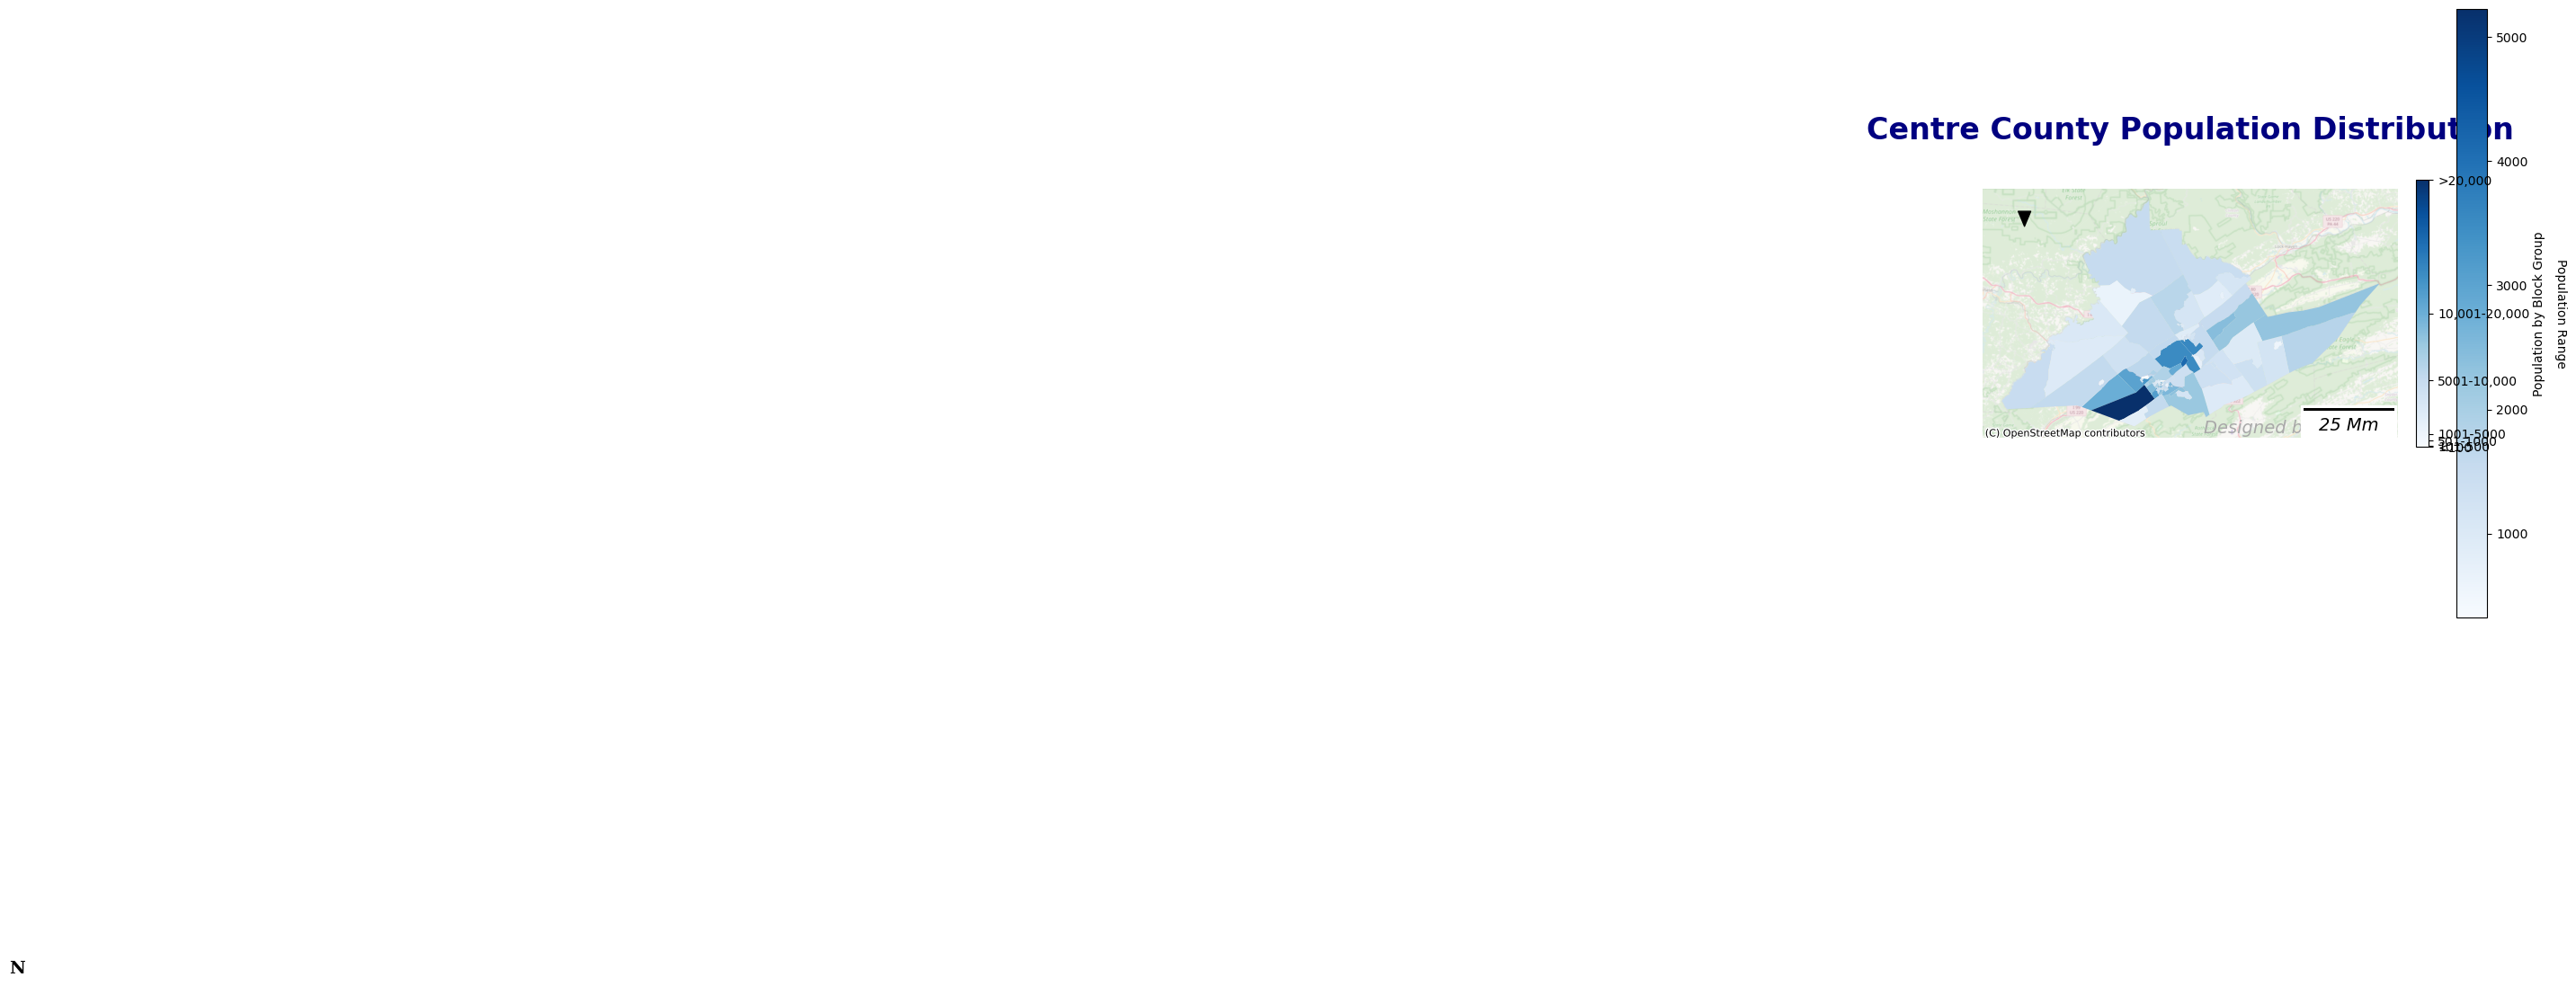

In [27]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 5

Revising the map, trial 1 / 1
Current map issues:
1. **Legend Clarity and Positioning**: The legend is overflowing the map space, particularly at the top end. It makes it confusing to associate the color ranges with the values.
2. **North Arrow Design**: The north arrow is too simplistic and could be enhanced to better fit the design of the map.
3. **Scale Bar Position and Style**: The scale bar is currently overlapping with the map's legend which can obscure data. Its style also lacks integration with the rest of the map's design.
4. **Color Contrast and Map Basemap Transparency**: The transparency of the basemap under the thematic layer makes it challenging to see the streets and geographic identifiers clearly. Also, the use of the color blue alone might benefit from a revised palette to enhance contrast.
5. **Title Placement and Style**: The title's current placement overlaps slightly with the top edge of the map frame, and its styling could be enhanced to be more visually appealing

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Ensure GeoPandas and other libraries are installed (if not already installed, uncomment the following lines)
# !pip install geopandas matplotlib contextily

def generate_thematic_map():
    # Load the population data from the GeoPackage
    gdf = gpd.read_file(r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\centre_county_CBG.gpkg")

    # Set up the plot with a specific size and resolution
    fig, ax = plt.subplots(figsize=(8, 11), dpi=300)

    # Plot the GeoDataFrame 
    gdf.plot(column='totalpopulation', cmap='viridis', legend=True, ax=ax,
             legend_kwds={'label': "Population by Block Group", 'orientation': "horizontal"})
    
    # Add basemap using Contextily - updated source to use OpenStreetMap.Mapnik
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Customize the legend if it exists
    legend = ax.get_legend()
    if legend:
        legend.set_bbox_to_anchor((1, 1))
    
    ax.set_title('Centre County Census Block Group Population', fontdict={'fontsize': 15, 'fontweight': '3'})

    # Add grid lines, north arrow, and scale bar
    ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    ax.text(0.5, -0.1, 'North Arrow: ↑', horizontalalignment='center', transform=ax.transAxes)  # Enhanced textual north arrow
    ax.text(0.5, -0.2, 'Scale: 1 inch = 1000 m', horizontalalignment='center', transform=ax.transAxes)  # Enhanced textual scale bar
    ax.annotate('Designer: LLM-Cat', xy=(0.1, 0.1), xycoords='figure fraction')

    # Save the figure
    plt.savefig('output_map.png')

# Call the function to generate the map
generate_thematic_map()

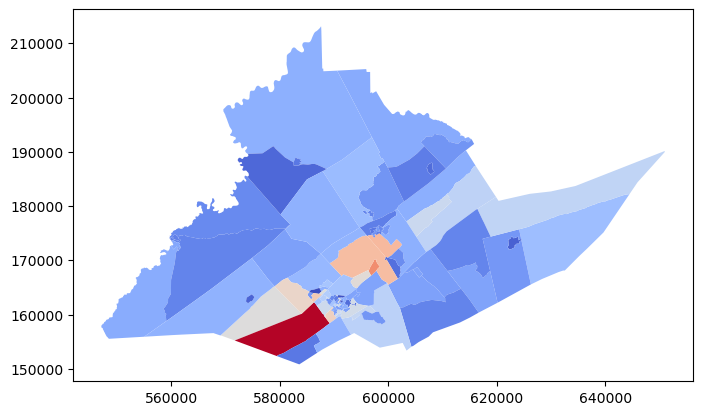

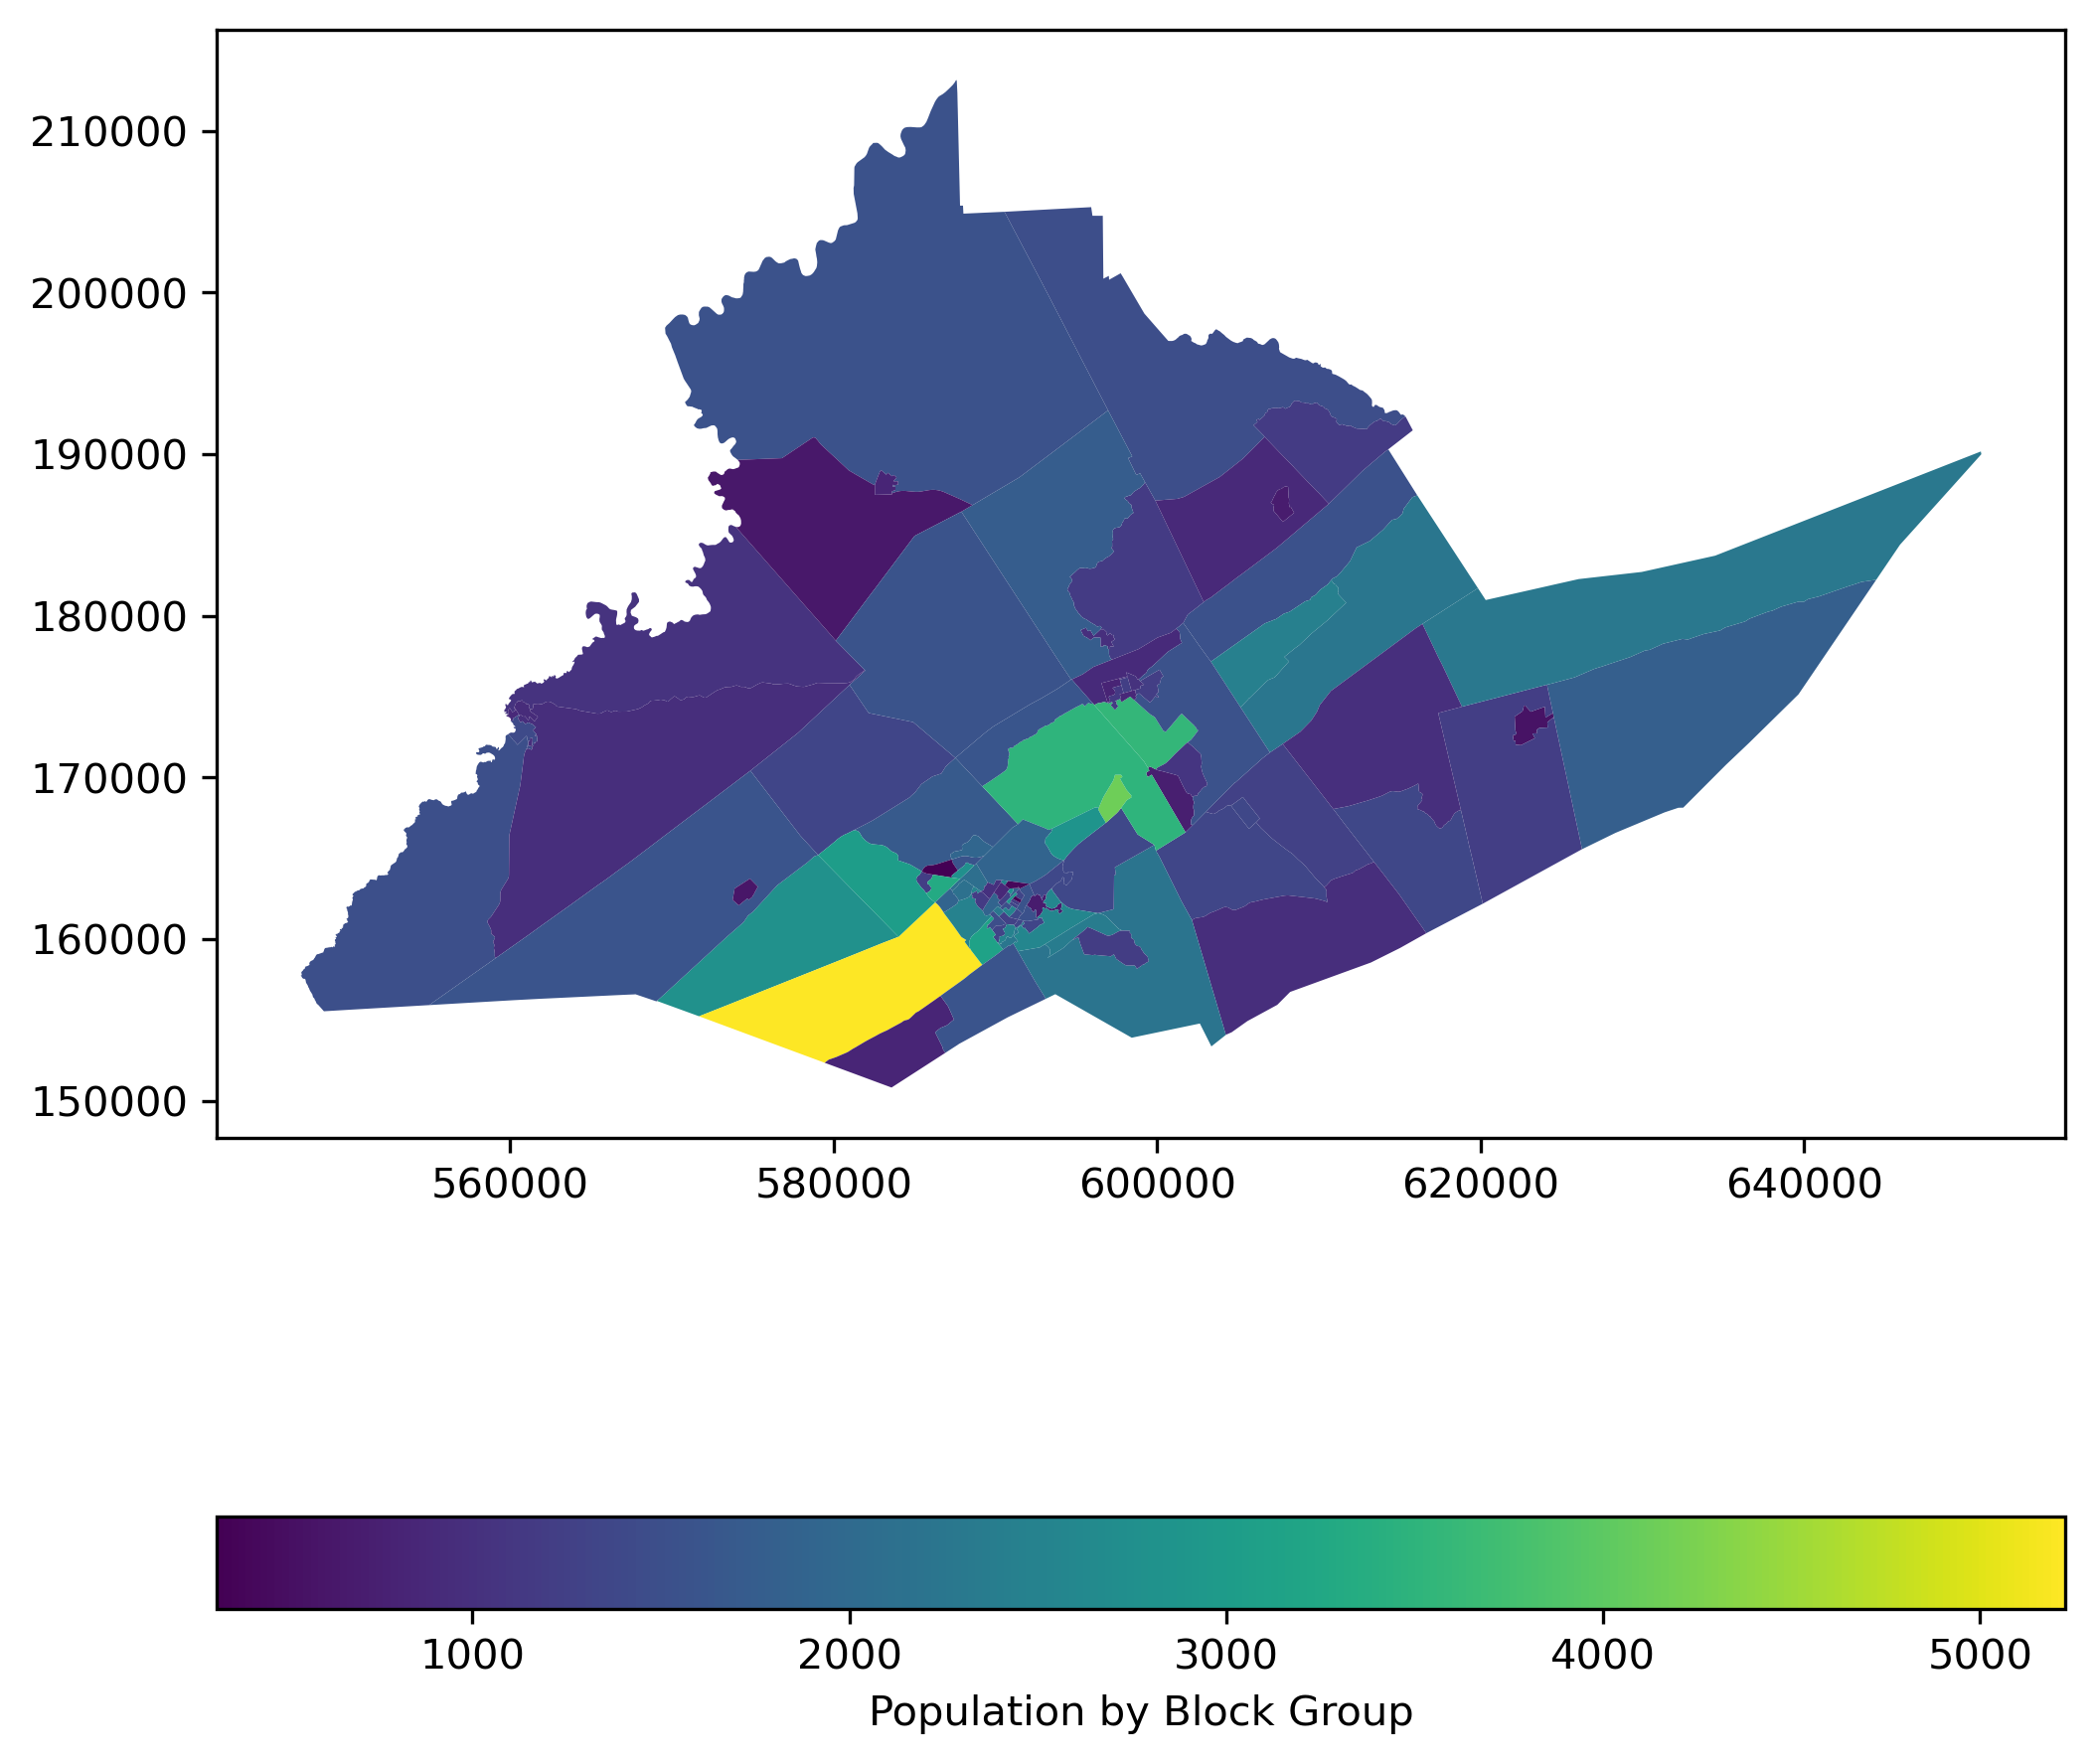

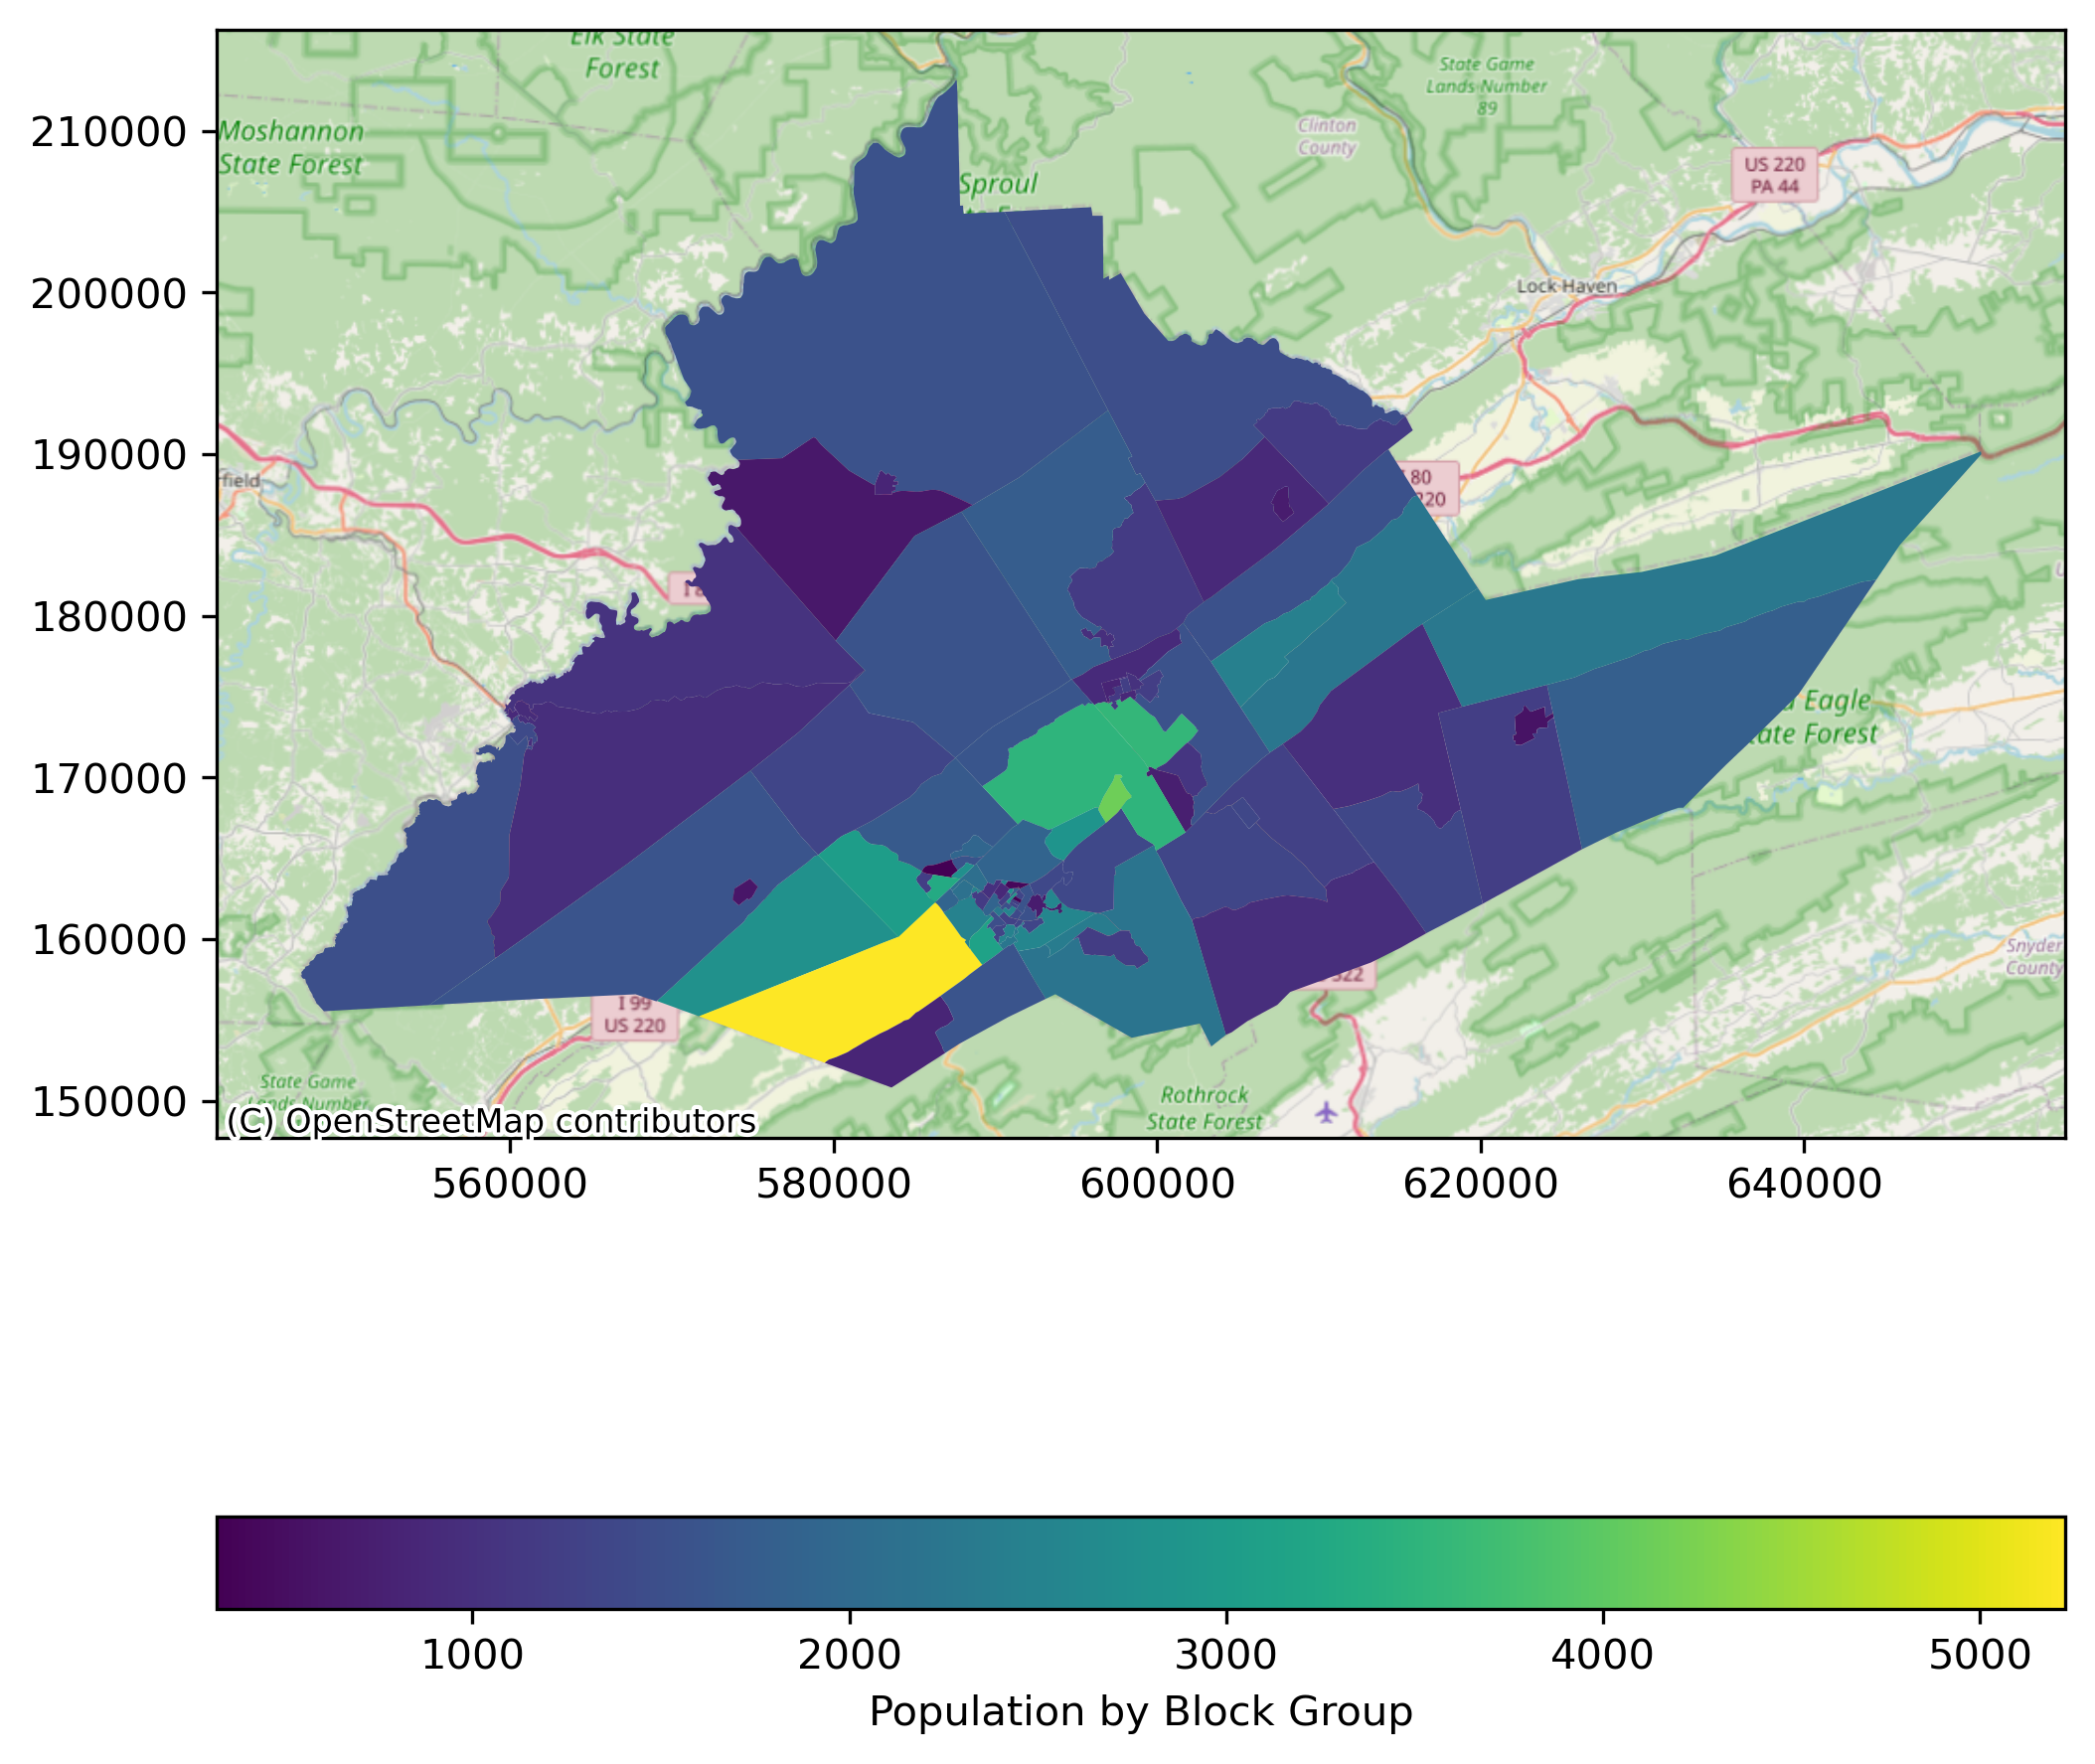

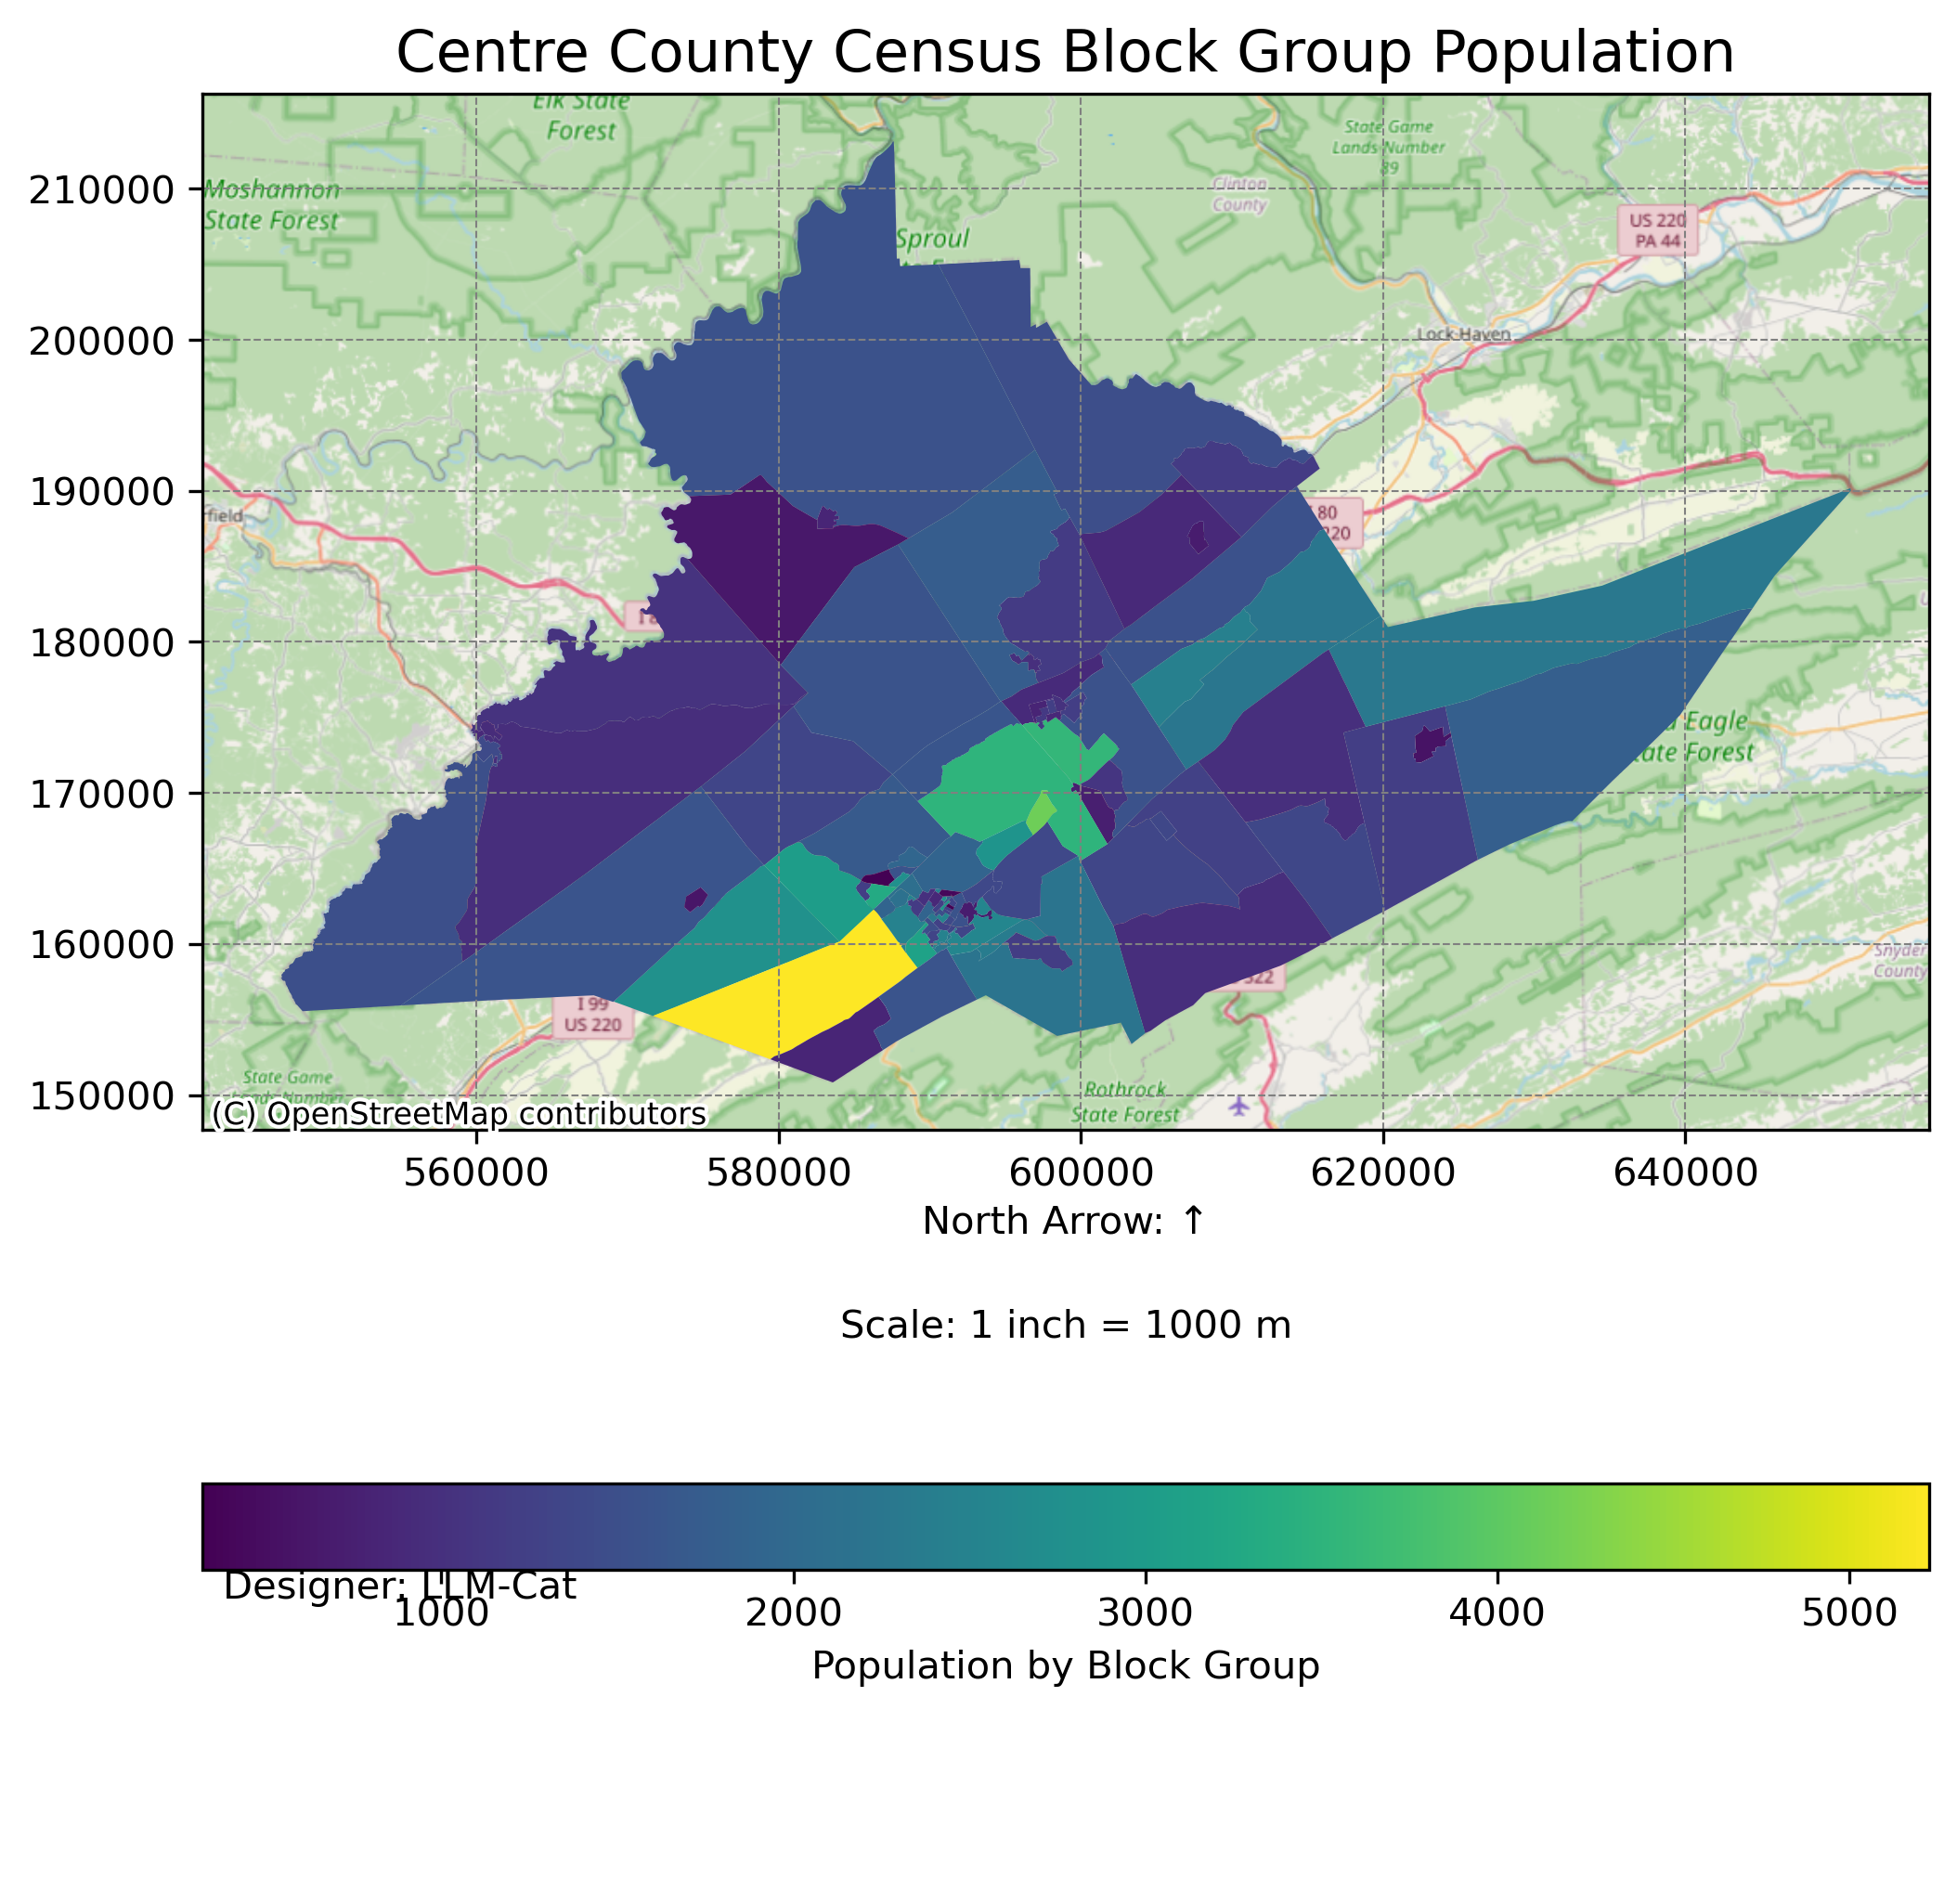

In [28]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))